### House Price Prediction


Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [472]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LinearRegression, LogisticRegression, \
LogisticRegressionCV, LassoCV, SGDRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, SelectKBest, f_regression, mutual_info_regression
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [1468]:
# Load the data
house_df = pd.read_csv('./housing.csv')

In [474]:
# inspect the column data types, 
#incorrect column types, and inspect for NaN's/missing values
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [475]:
# make a copy of the dataframe before making any changes
house = house_df.copy()

In [476]:
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [477]:
# remove rows that has MSZoning set to a non-residential value
house.drop(house[house.MSZoning=='C (all)'].index, inplace=True)

In [478]:
# list columns with Nan's
house.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1443
MiscFeature     1398
Alley           1361
Fence           1172
FireplaceQu      681
LotFrontage      259
GarageCond        79
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

In [479]:
house.loc[1379,:]['Electrical']

nan

In [480]:
# replace NaN's of a given column with a specified value
def replace_NaNs(replace_dict):
#    house.loc[house.Electrical.isnull(),'Electrical']='No Electrical'
#    house.loc[:,house.column.isnull()] = value
    replace_list=[]
    for column, NaN_value in replace_dict.items():
        try:
            house.loc[house[column].isnull(),column]=NaN_value
            replace_list.append('replace function successful for column: ' + column)
        except:
            replace_list.append('error in replace function for column: ' + column)
    return replace_list

In [481]:
# All NaN's for 'Garage' columns are referring to the same rows (79 in total)
house[(house.GarageYrBlt.isnull() & house.GarageCond.isnull() & house.GarageType.isnull() & house.GarageFinish.isnull())].head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
39,40,90,RL,65.0,6040,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,AdjLand,82000
48,49,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
78,79,90,RL,72.0,10778,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,136500
89,90,20,RL,60.0,8070,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,123600
99,100,20,RL,77.0,9320,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,400,1,2010,WD,Normal,128950
108,109,50,RM,85.0,8500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,115000
125,126,190,RM,60.0,6780,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,84500
127,128,45,RM,55.0,4388,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,87000
140,141,20,RL,70.0,10500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,ConLI,Normal,115000
148,149,20,RL,63.0,7500,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Normal,141000


In [482]:
# all MasVnrArea and MasVnrType that have NaN's refer to the same rows
house[(house.MasVnrArea.isnull() & house.MasVnrType.isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,235,60,RL,NaN,7851,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,216500
529,530,20,RL,NaN,32668,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Alloca,200624
650,651,60,FV,65.0,8125,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,205950
936,937,20,RL,67.0,10083,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,WD,Normal,184900
973,974,20,FV,95.0,11639,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,New,Partial,182000
977,978,120,FV,35.0,4274,Pave,Pave,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,11,2007,New,Partial,199900
1243,1244,20,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,New,Partial,465000
1278,1279,60,RL,75.0,9473,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,237000


In [483]:
# parse data dictionary to store categorical variables in a dictionary, and non-categorical variables in a separate list
with open('data_description - to parse - partial.txt', 'r') as file_reader:
    parse_text = file_reader.read()
variables_list = parse_text.split('\n')

categorical_variables_dict = {}
numeric_variables_list = []
# convert categorical variables to dictionary
next_entry_type = 'categorical_feature'
for entry in variables_list:
    if (entry.strip() and next_entry_type == 'categorical_feature'):
        key = entry.lower().strip()
        next_entry_type = 'categorical_value'
        value_list = []
    # it has value, therefore it's a categorical column
    elif (entry.strip() and next_entry_type == 'categorical_value'): # it has 
        has_value = True
        value_list.append(entry.lower().strip())
    else: # if it is a ''
        if has_value:
            categorical_variables_dict[key] = value_list
        # it has no value, therefore it's a numeric column
        else: 
            numeric_variables_list.append(key)
        next_entry_type = 'categorical_feature'
        has_value=False

# add the last variable-features set to the dictionary
if has_value:
    categorical_variables_dict[key] = value_list
else:
    numeric_variables_list.append(entry)

print(categorical_variables_dict)
print(numeric_variables_list)

{'mssubclass': ['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '150', '160', '180', '190'], 'mszoning': ['a', 'c', 'fv', 'i', 'rh', 'rl', 'rp', 'rm'], 'street': ['grvl', 'pave'], 'alley': ['grvl', 'pave', 'na']}
['lotfrontage', 'lotarea']


In [484]:
# assess values for categorical variables by comparing actual columns to those in the data dictionary
# list categorical values that are not listed in data dictionary - for evaluation and possible cleaning of categorical values
for column in house.columns:
    if column.lower() in categorical_variables_dict.keys():
        print(column.lower())

mssubclass
mszoning
street
alley


In [485]:
# replace columns with NaN with appropriate value as per data dictionary
replace_dict = { 'PoolQC':'No Pool',
'MiscFeature' : 'None',
'Alley' : 'No alley access',
'Fence' : 'No Fence',
'FireplaceQu' : 'No Fireplace',
'LotFrontage' : 0,
'GarageCond' : 'No Garage',
'GarageType' : 'No Garage',
'GarageYrBlt' : 0,
'GarageFinish' : 'No Garage',
'GarageQual' : 'No Garage',
'BsmtExposure' : 'No Basement',
'BsmtFinType2' : 'No Basement',
'BsmtFinType1' : 'No Basement',
'BsmtCond' : 'No Basement',
'BsmtQual' : 'No Basement',
'MasVnrArea' : 0,
'MasVnrType' : 'None',
'Electrical' : 'None'
}

replace_NaNs(replace_dict)

['replace function successful for column: PoolQC',
 'replace function successful for column: MiscFeature',
 'replace function successful for column: Alley',
 'replace function successful for column: Fence',
 'replace function successful for column: FireplaceQu',
 'replace function successful for column: LotFrontage',
 'replace function successful for column: GarageCond',
 'replace function successful for column: GarageType',
 'replace function successful for column: GarageYrBlt',
 'replace function successful for column: GarageFinish',
 'replace function successful for column: GarageQual',
 'replace function successful for column: BsmtExposure',
 'replace function successful for column: BsmtFinType2',
 'replace function successful for column: BsmtFinType1',
 'replace function successful for column: BsmtCond',
 'replace function successful for column: BsmtQual',
 'replace function successful for column: MasVnrArea',
 'replace function successful for column: MasVnrType',
 'replace functi

In [486]:
# verify that there are no NaN's in any of the columns
house.isnull().sum().sort_values(ascending=False).head()

SalePrice      0
Heating        0
RoofStyle      0
RoofMatl       0
Exterior1st    0
dtype: int64

In [487]:
#house_dum = dummify(house)

In [488]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [489]:
house.describe().T[['min','50%', 'mean', 'std', 'max']]

,min,50%,mean,std,max
Id,1.0,731.5,731.364138,421.554345,1460.0
MSSubClass,20.0,50.0,56.903448,42.265033,190.0
LotFrontage,0.0,63.0,57.540000,34.719920,313.0
LotArea,1300.0,9496.0,10523.831724,10012.185355,215245.0
OverallQual,1.0,6.0,6.114483,1.372860,10.0
OverallCond,1.0,5.0,5.582069,1.107330,9.0
YearBuilt,1872.0,1973.0,1971.593103,30.022696,2010.0
YearRemodAdd,1950.0,1994.0,1985.049655,20.552319,2010.0
MasVnrArea,0.0,0.0,103.828276,181.150114,1600.0
BsmtFinSF1,0.0,384.0,445.162759,456.353871,5644.0


In [490]:
# get the numerical columns
numerical_columns=list(house.describe().T.index)
numerical_columns

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [491]:
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1450.000000,1450.000000,1450.00000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,...,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,731.364138,56.903448,57.54000,10523.831724,6.114483,5.582069,1971.593103,1985.049655,103.828276,445.162759,...,94.826897,46.537931,21.536552,3.433103,15.096552,2.777931,43.365517,6.312414,2007.812414,181654.942069
std,421.554345,42.265033,34.71992,10012.185355,1.372860,1.107330,30.022696,20.552319,181.150114,456.353871,...,125.560863,65.222761,60.838826,29.416948,55.893399,40.315051,497.636495,2.698244,1.326321,79176.485241
min,1.000000,20.000000,0.00000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,366.250000,20.000000,41.25000,7544.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,731.500000,50.000000,63.00000,9496.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163945.000000
75%,1096.750000,70.000000,79.00000,11613.500000,7.000000,6.000000,2001.000000,2004.000000,166.000000,713.750000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.00000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [492]:
x = np.percentile(house.LotArea, 25)
y = np.percentile(house.LotArea, 75)
print(x)
print(y)
print(y-x)

7544.5
11613.5
4069.0


In [493]:
# iterate through columns to see if it has outliers, or values beyond 5 times IQR from 75th percentile and 25th percentile
# set it to 5xIQR, since 1.5xIQR yielded a great number of observations for the columns
has_outlier_columns_plus_iqr=[]
has_outlier_columns_minus_iqr=[]

for column in numerical_columns:
    perc_25 = np.percentile(house[column], 25)
    perc_75 = np.percentile(house[column], 75)
    iqr = perc_75 - perc_25
    
    outlier_plus_iqr_value = perc_75 + (5 * iqr)
    outlier_minus_iqr_value = perc_25 - (5 * iqr)
    
    if house[column].max() > outlier_plus_iqr_value:
        has_outlier_columns_plus_iqr.append(column)
        print(column, ': Outliers abve 5xIQR: ')
        print(house[house[column] > outlier_plus_iqr_value][column])
    if house[column].min() < outlier_minus_iqr_value:
        has_outlier_columns_minus_iqr.append(column)
        print(column, ': Outliers below 5xIQR: ')
        print(house[house[column] < outlier_plus_iqr_value][column])

# print('probable outliers (plus 5xIQR): ')
# print(has_outlier_columns_plus_iqr)
# print('\n probable outliers (minus 5xIQR): ')
# print(has_outlier_columns_minus_iqr)

LotFrontage : Outliers abve 5xIQR: 
934     313.0
1298    313.0
Name: LotFrontage, dtype: float64
LotArea : Outliers abve 5xIQR: 
53       50271
249     159000
271      39104
313     215245
335     164660
384      53107
411      34650
451      70761
457      53227
523      40094
529      32668
661      46589
706     115149
769      53504
848      45600
1169     35760
1184     35133
1190     32463
1287     36500
1298     63887
1396     57200
Name: LotArea, dtype: int64
MasVnrArea : Outliers abve 5xIQR: 
58      1031.0
70      1115.0
115     1129.0
297     1600.0
691     1170.0
808     1047.0
1169    1378.0
Name: MasVnrArea, dtype: float64
BsmtFinSF1 : Outliers abve 5xIQR: 
1298    5644
Name: BsmtFinSF1, dtype: int64
BsmtFinSF2 : Outliers abve 5xIQR: 
7         32
24       668
26       486
42        93
43       491
44       506
52       712
73       362
77        41
107      169
113      869
114      150
116      670
129       28
153     1080
165      181
166      768
172      215
173   

In [494]:
# iterate through columns to see if it has outliers, or values beyond 3 times standard deviation, in both directions
has_outlier_columns_plus3std=[]
has_outlier_columns_minus3std=[]

for column in numerical_columns:
    outlier_plus3std_value = house[column].mean() + (3 * house[column].std())
    outlier_minus3std_value = house[column].mean() - (3 * house[column].std())
    if house[column].max() > outlier_plus3std_value:
        has_outlier_columns_plus3std.append(column)
    if house[column].min() < outlier_plus3std_value:
        has_outlier_columns_minus3std.append(column)

print('probable outliers (plus 3std): ')
print(has_outlier_columns_plus3std)
print('\n probable outliers (minus 3std): ')
print(has_outlier_columns_minus3std)

probable outliers (plus 3std): 
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

 probable outliers (minus 3std): 
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


#### From above calculation, majority of numerical columns were tagged as having outliers (plus/minus 3std). Thus it may not be practical to address outliers by referencing the calculation for both 3 times standard deviation and 5 times interquartile range(IQR).

## More EDA on whole dataset (Fixed and Non-Fixed Features Combined)

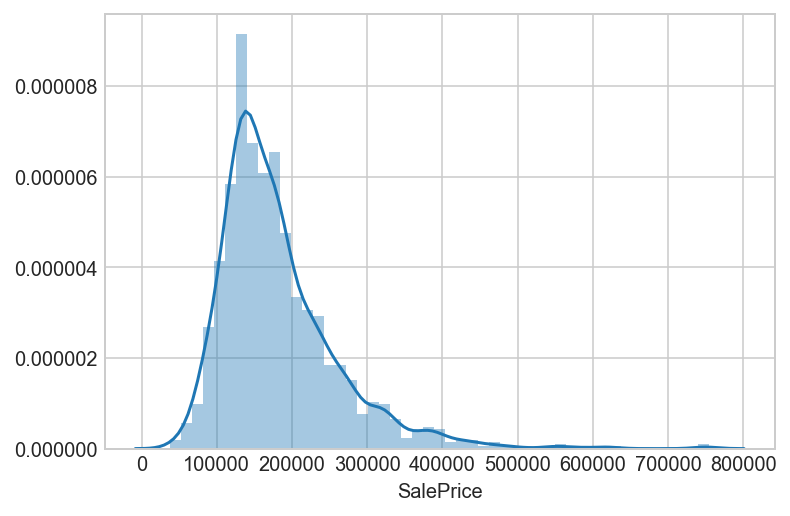

In [495]:
sns.distplot(house.SalePrice)

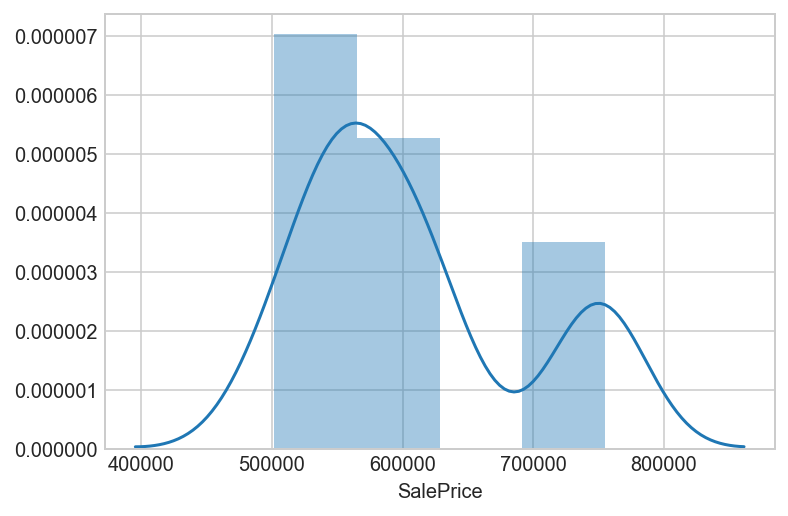

In [496]:
sns.distplot(house[house.SalePrice > 500000]['SalePrice'])

In [497]:
house[house.SalePrice > 500000][['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']].sort_values('SalePrice', ascending=False)

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF
691,755000,10,4316,3,832,2444
1182,745000,10,4476,3,813,2396
1169,625000,10,3627,3,807,1930
898,611657,9,2364,3,820,2330
803,582933,9,2822,3,1020,1734
1046,556581,9,2868,3,716,1992
440,555000,10,2402,3,672,3094
769,538000,8,3279,3,841,1650
178,501837,9,2234,3,1166,2216


In [498]:
house['GrLivArea'].describe()

count    1450.000000
mean     1517.698621
std       525.154207
min       334.000000
25%      1131.250000
50%      1466.000000
75%      1779.000000
max      5642.000000
Name: GrLivArea, dtype: float64

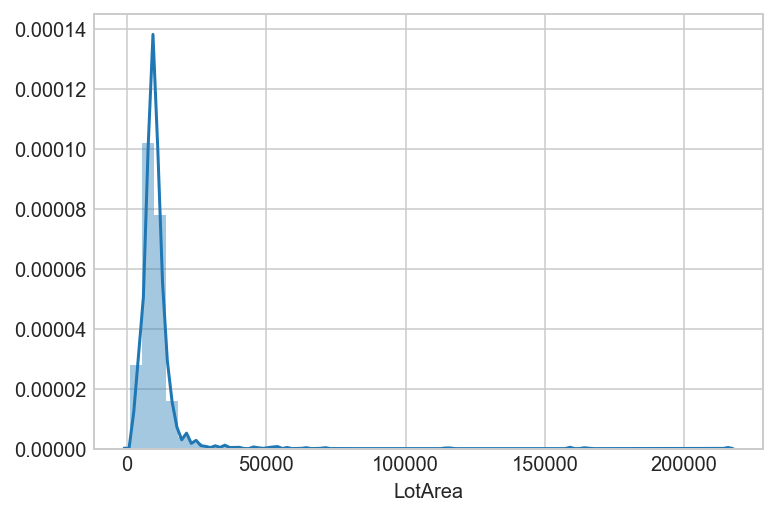

In [499]:
sns.distplot(house.LotArea)

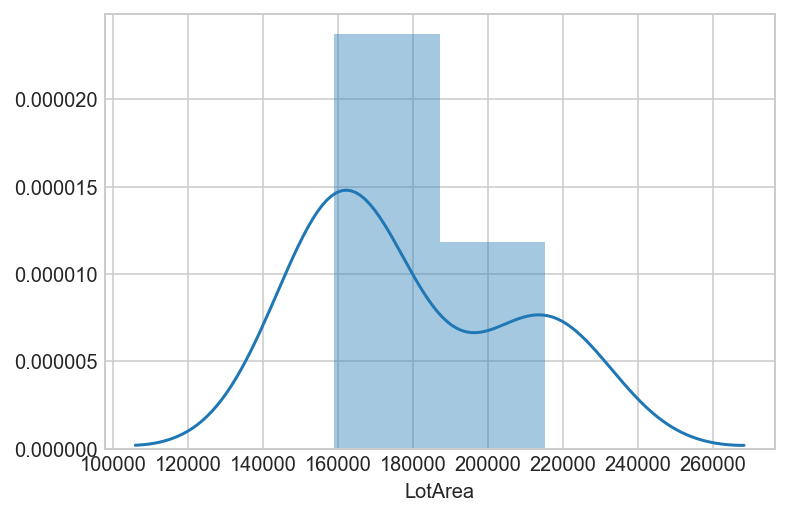

In [500]:
sns.distplot(house[house.LotArea > 150000]['LotArea'])

In [501]:
house[house.LotArea > 150000][['LotArea', 'SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']].sort_values('LotArea', ascending=False)

,LotArea,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF
313,215245,375000,7,2036,2,513,2136
335,164660,228950,5,1786,2,529,1499
249,159000,277000,6,2144,2,389,1444


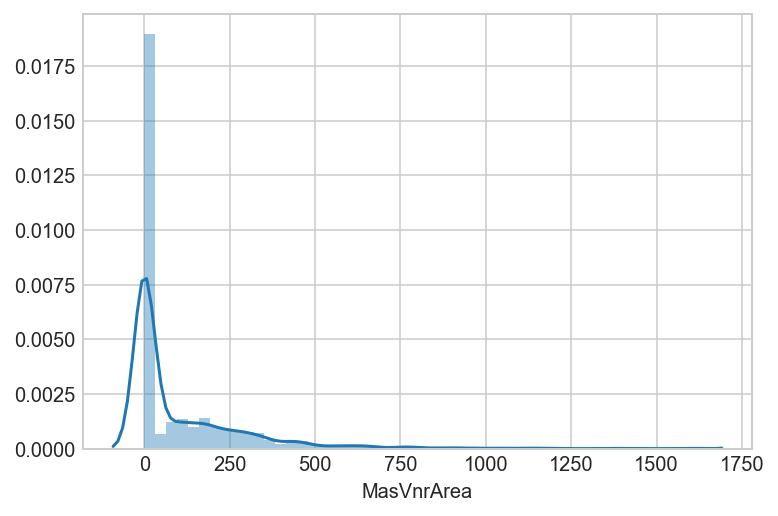

In [502]:
sns.distplot(house.MasVnrArea)

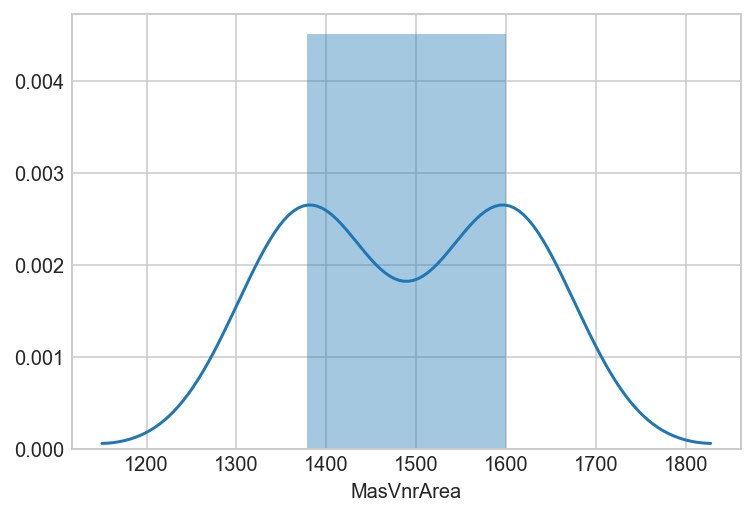

In [503]:
sns.distplot(house[house.MasVnrArea>1250]['MasVnrArea'])

In [504]:
house[house.MasVnrArea > 1250][['MasVnrArea', 'SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']].sort_values('MasVnrArea', ascending=False)

,MasVnrArea,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF
297,1600.0,239000,7,1950,2,576,975
1169,1378.0,625000,10,3627,3,807,1930


In [505]:
# get top 15 features with highest correlation with SalePrice
house_corr_saleprice_columns = list(house.corrwith(house.SalePrice).sort_values(ascending=False).head(15).index)

Text(0.5,1,'Top 15 correlated features to Sale Price - Entire Feature Set')

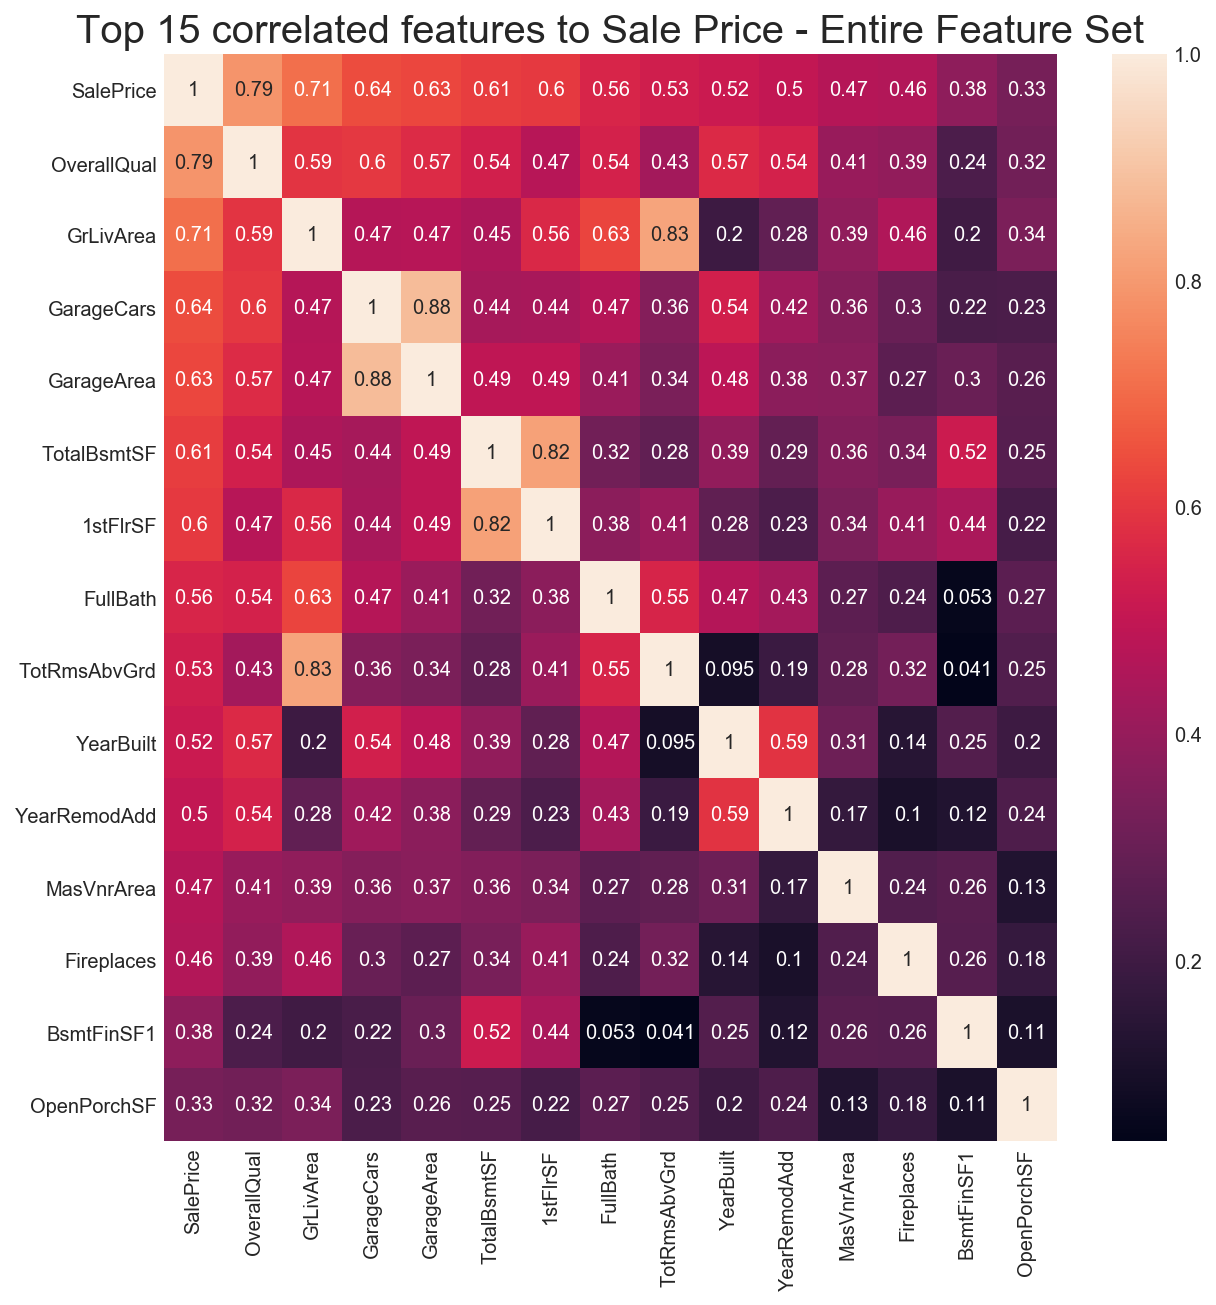

In [506]:
# plot the correlation heatmap for the top 15 features
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
sns.heatmap(house[house_corr_saleprice_columns].corr(), annot=True, ax=ax)
ax.set_title('Top 15 correlated features to Sale Price - Entire Feature Set', fontsize=20)

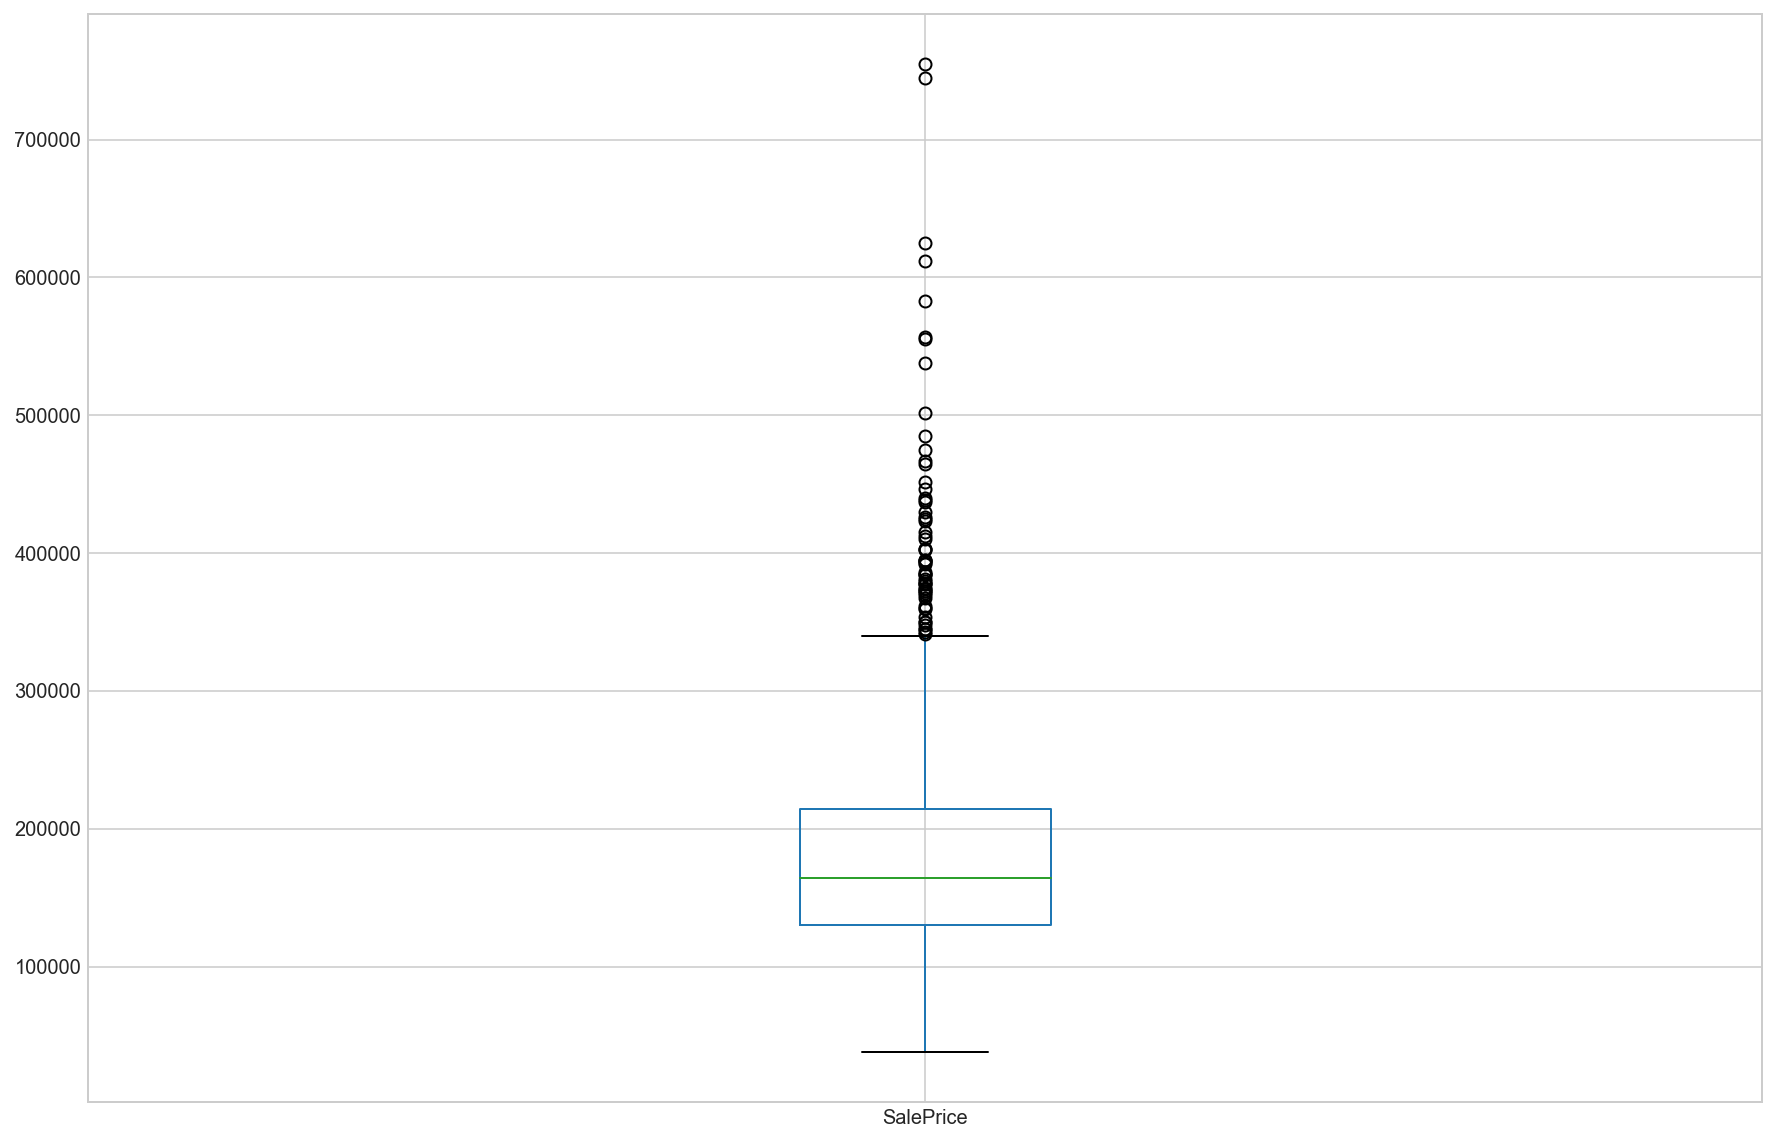

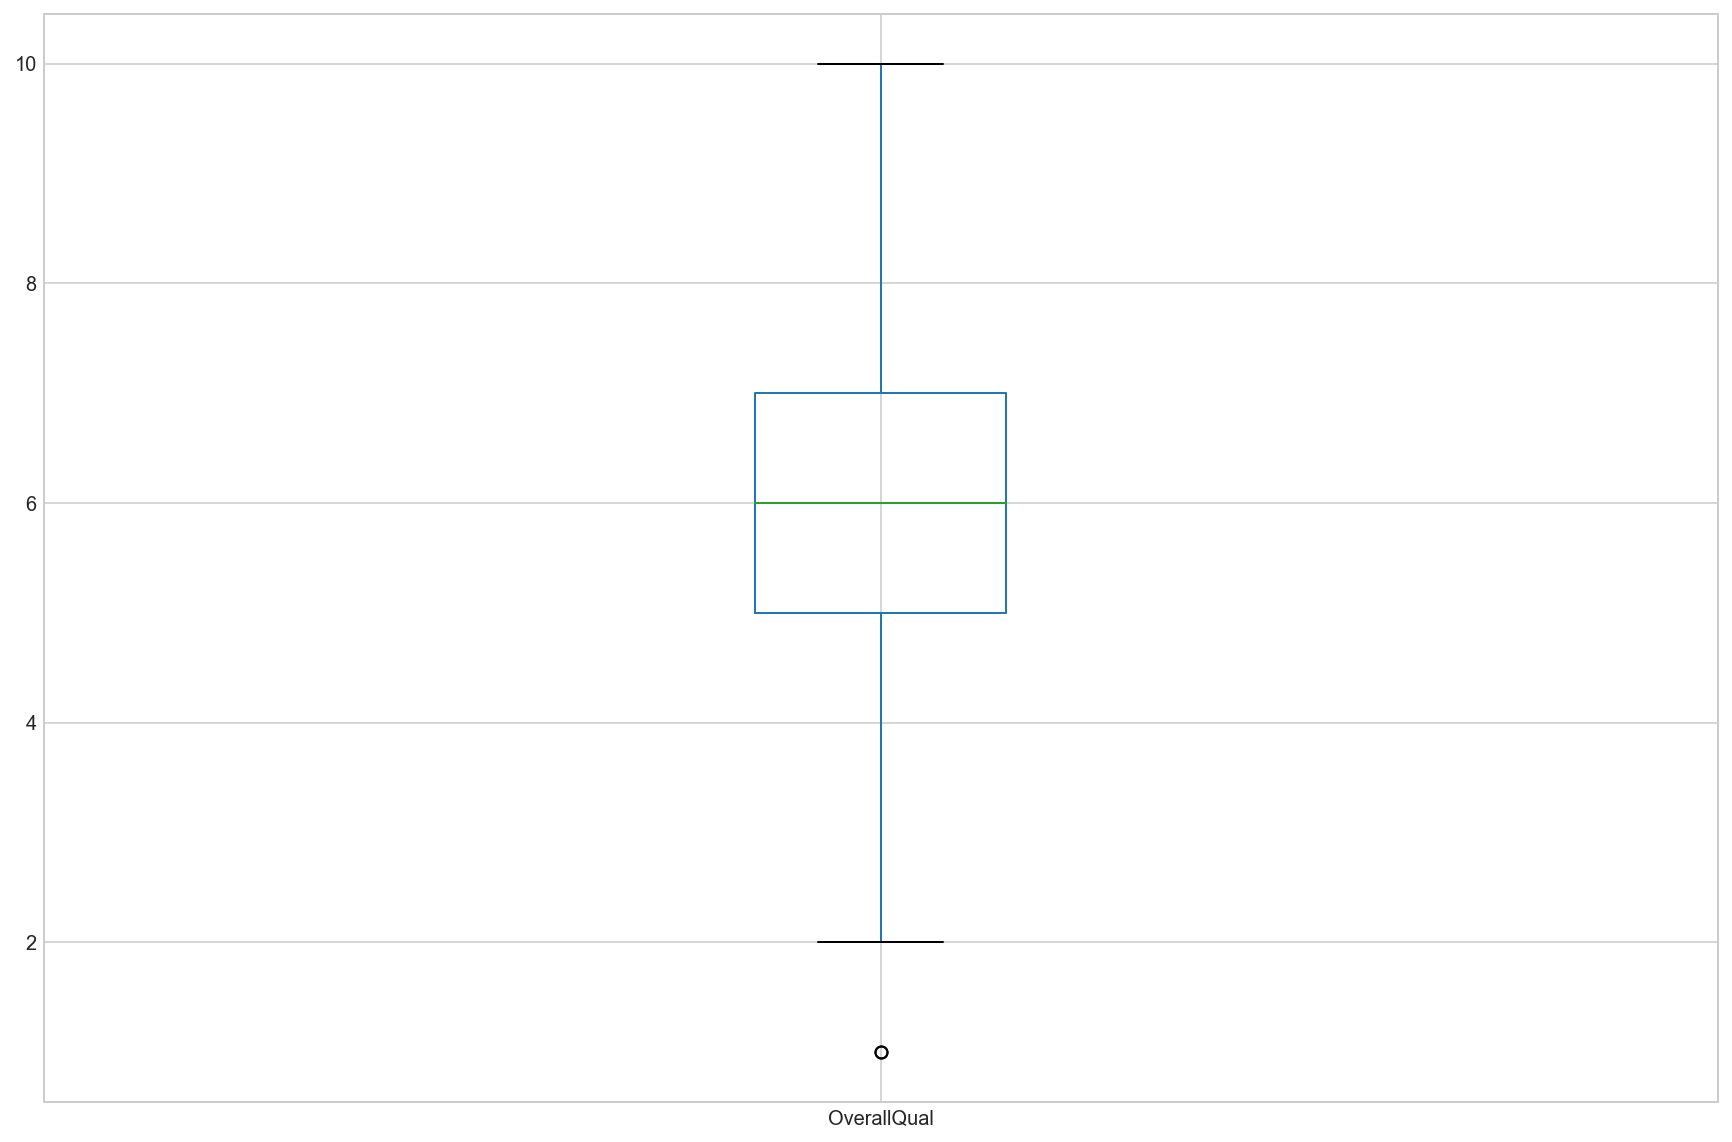

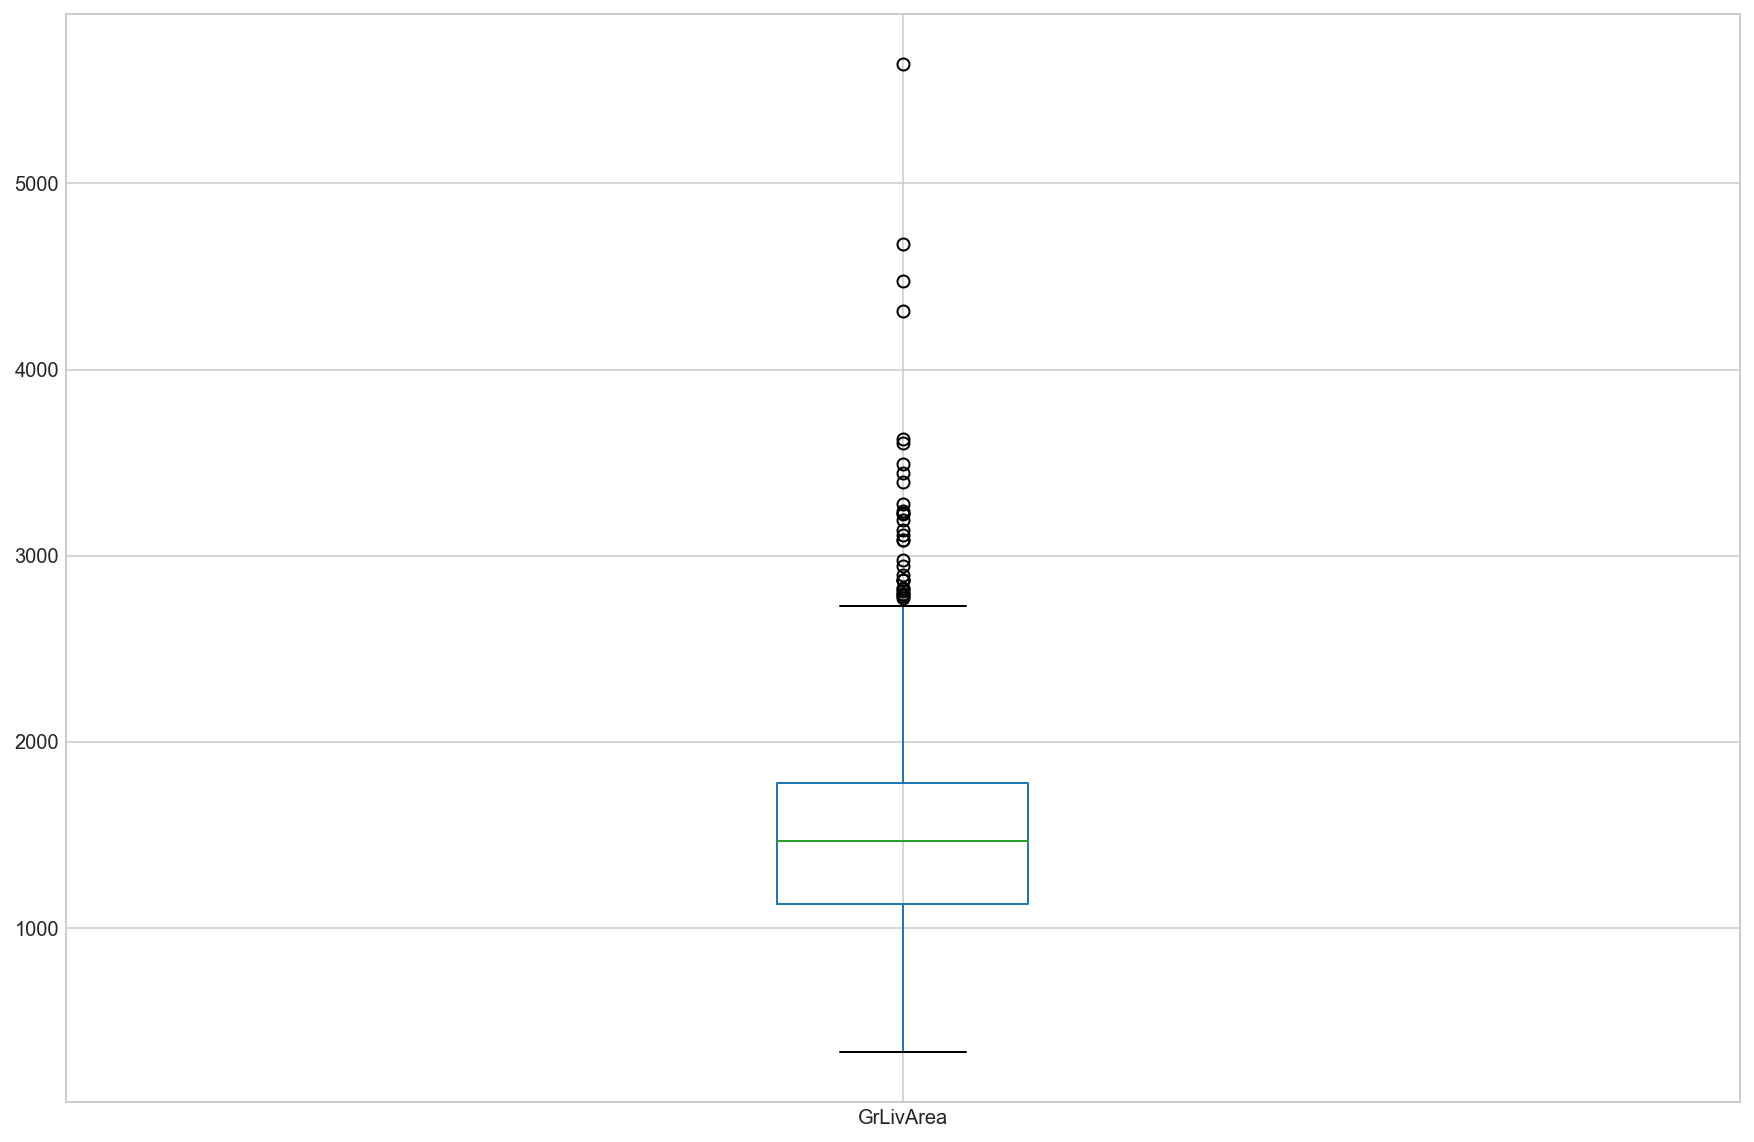

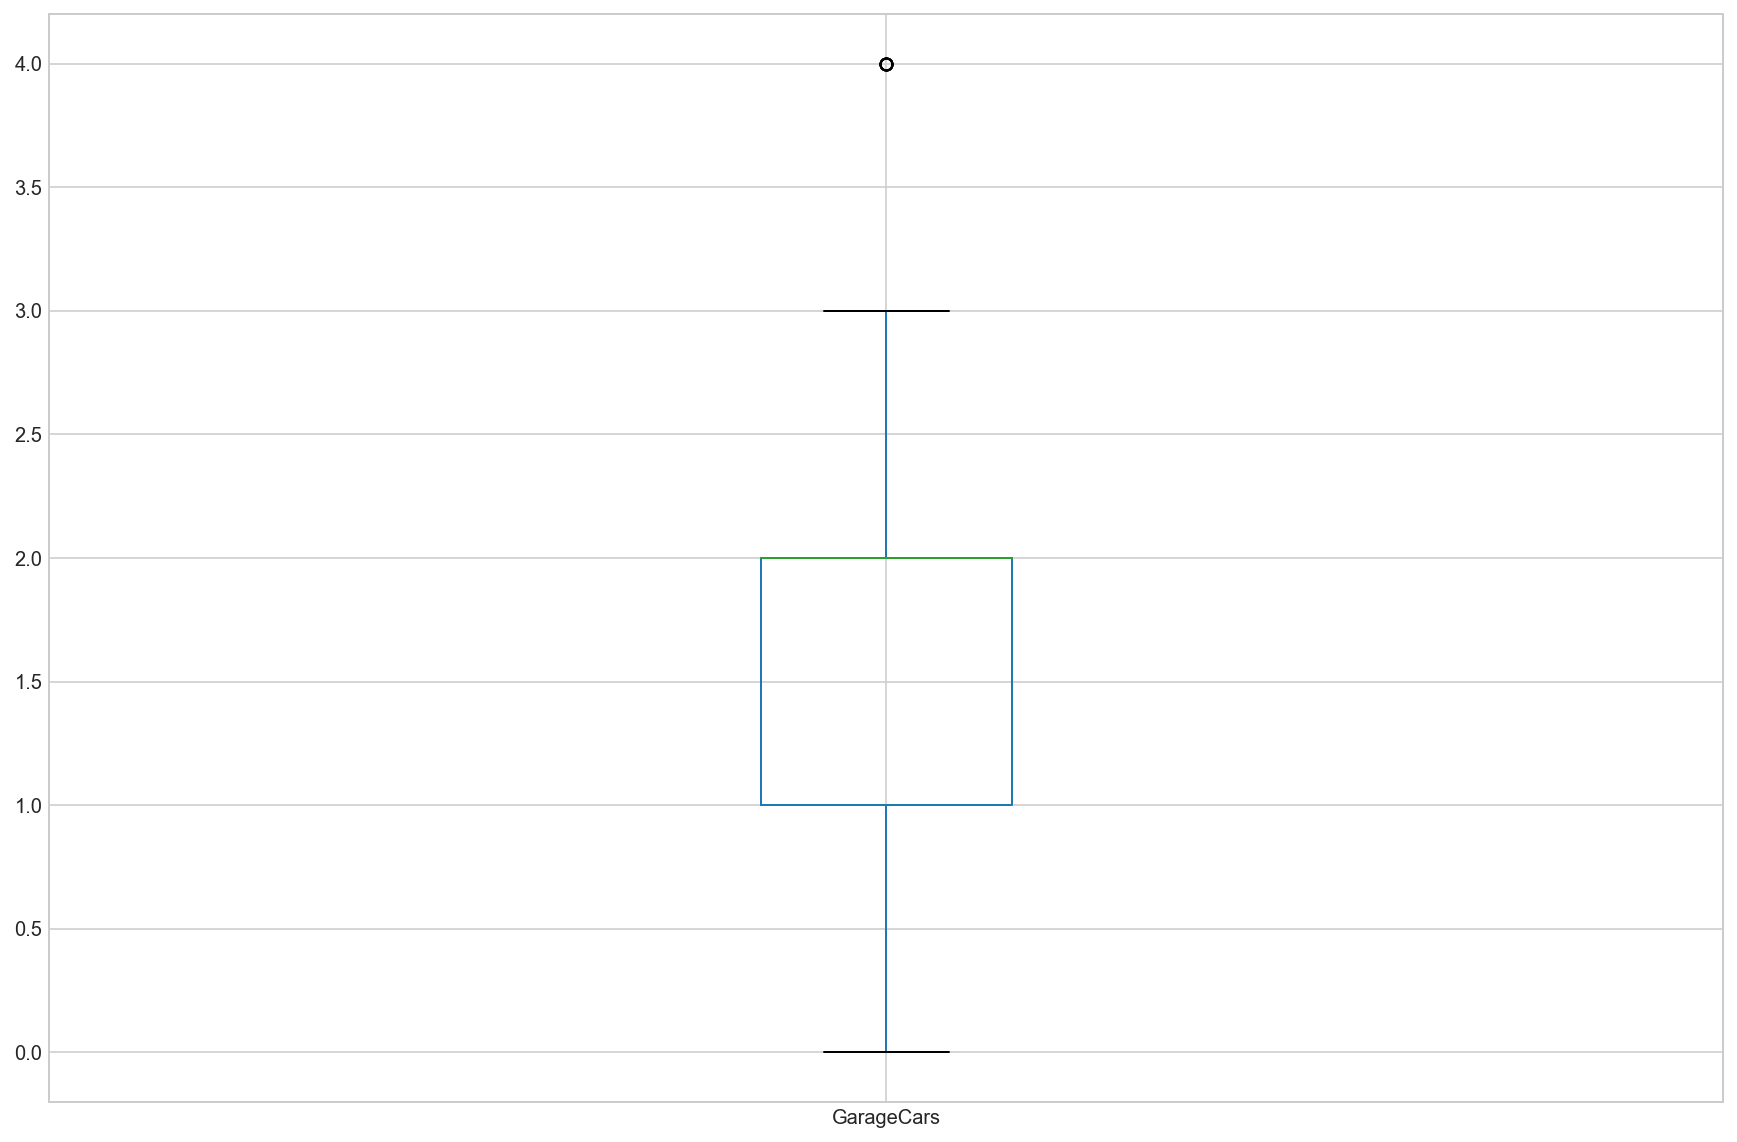

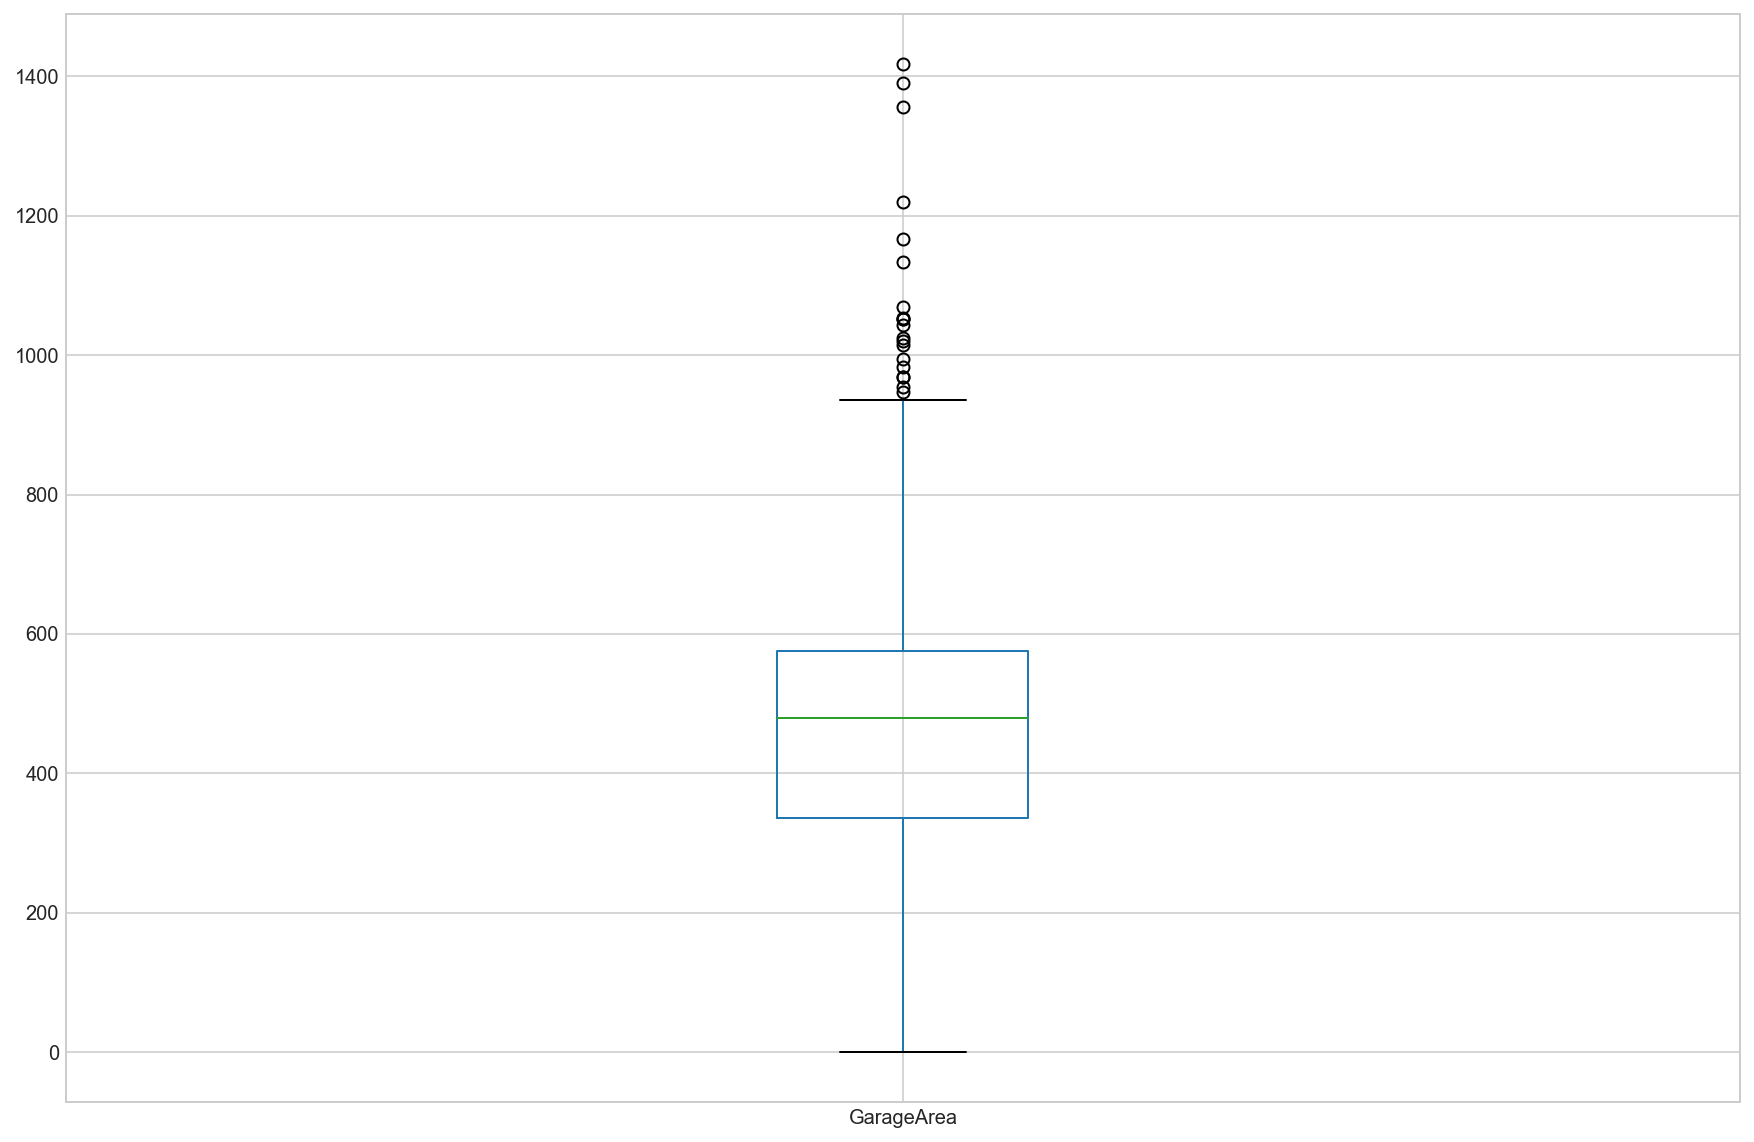

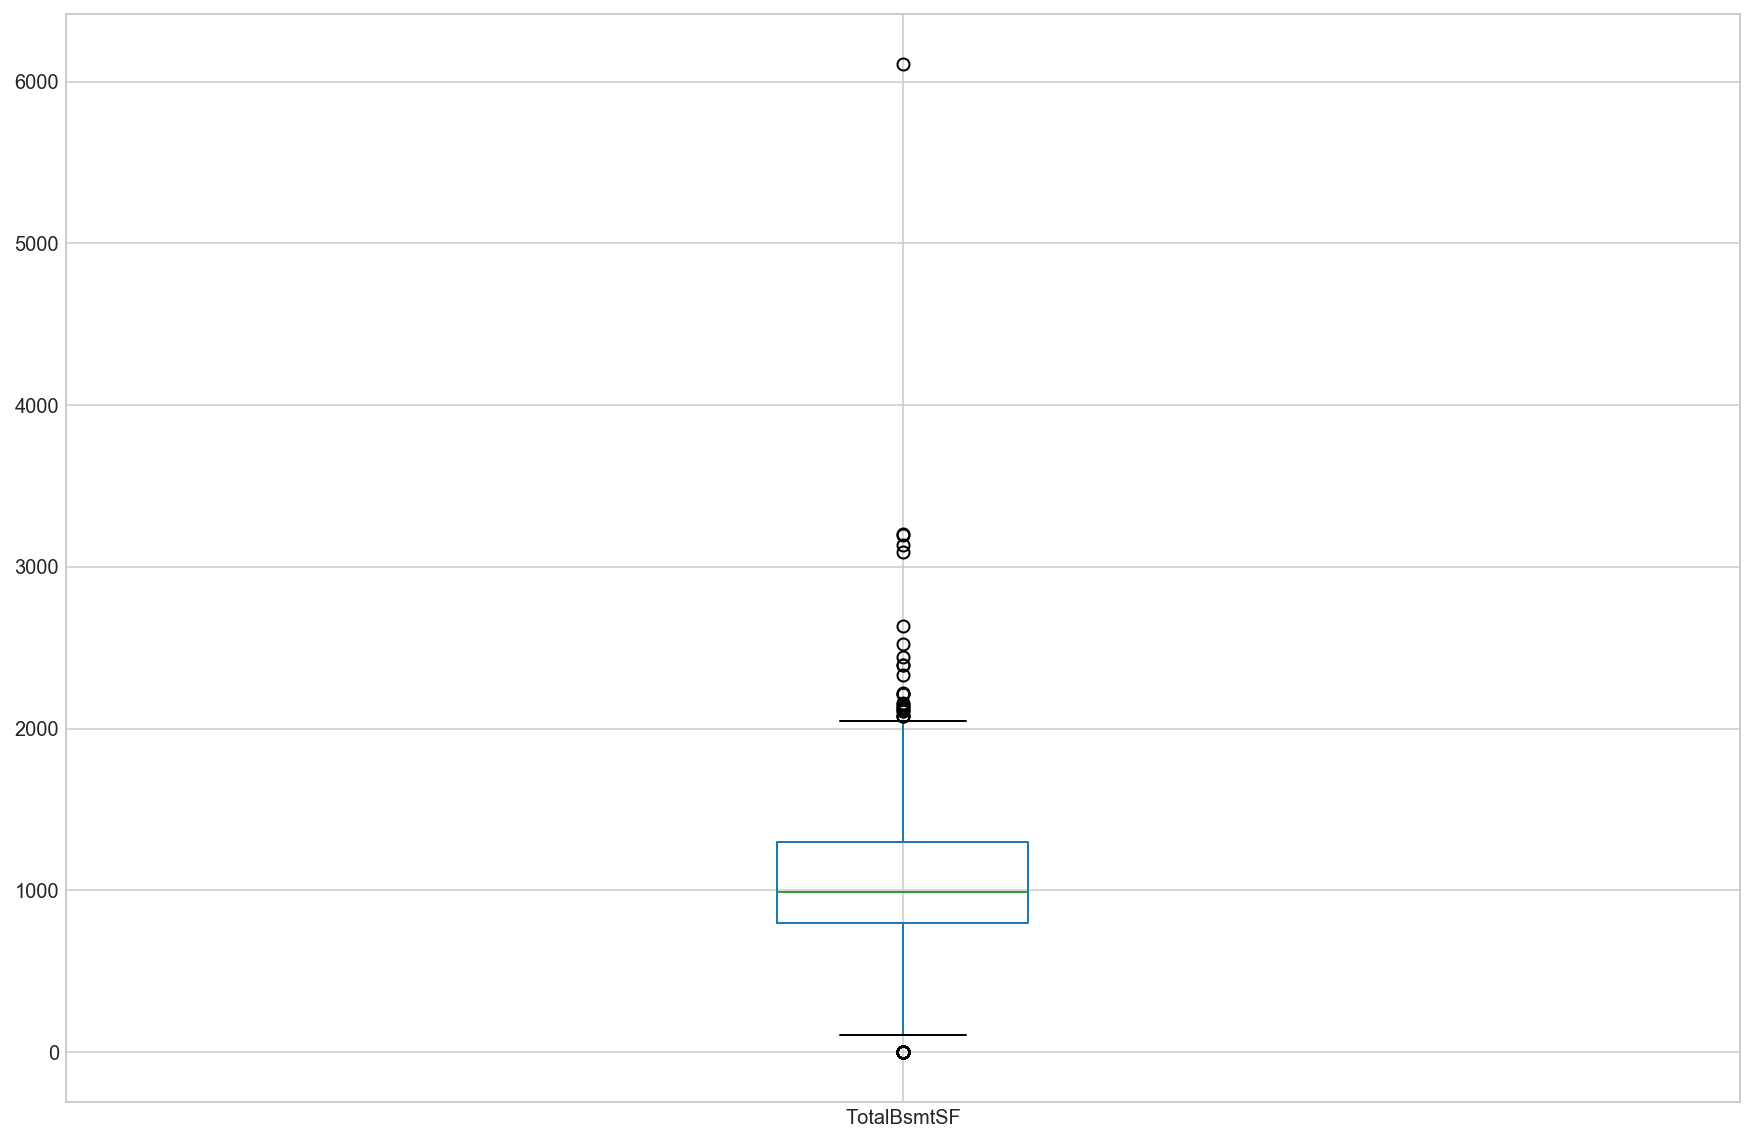

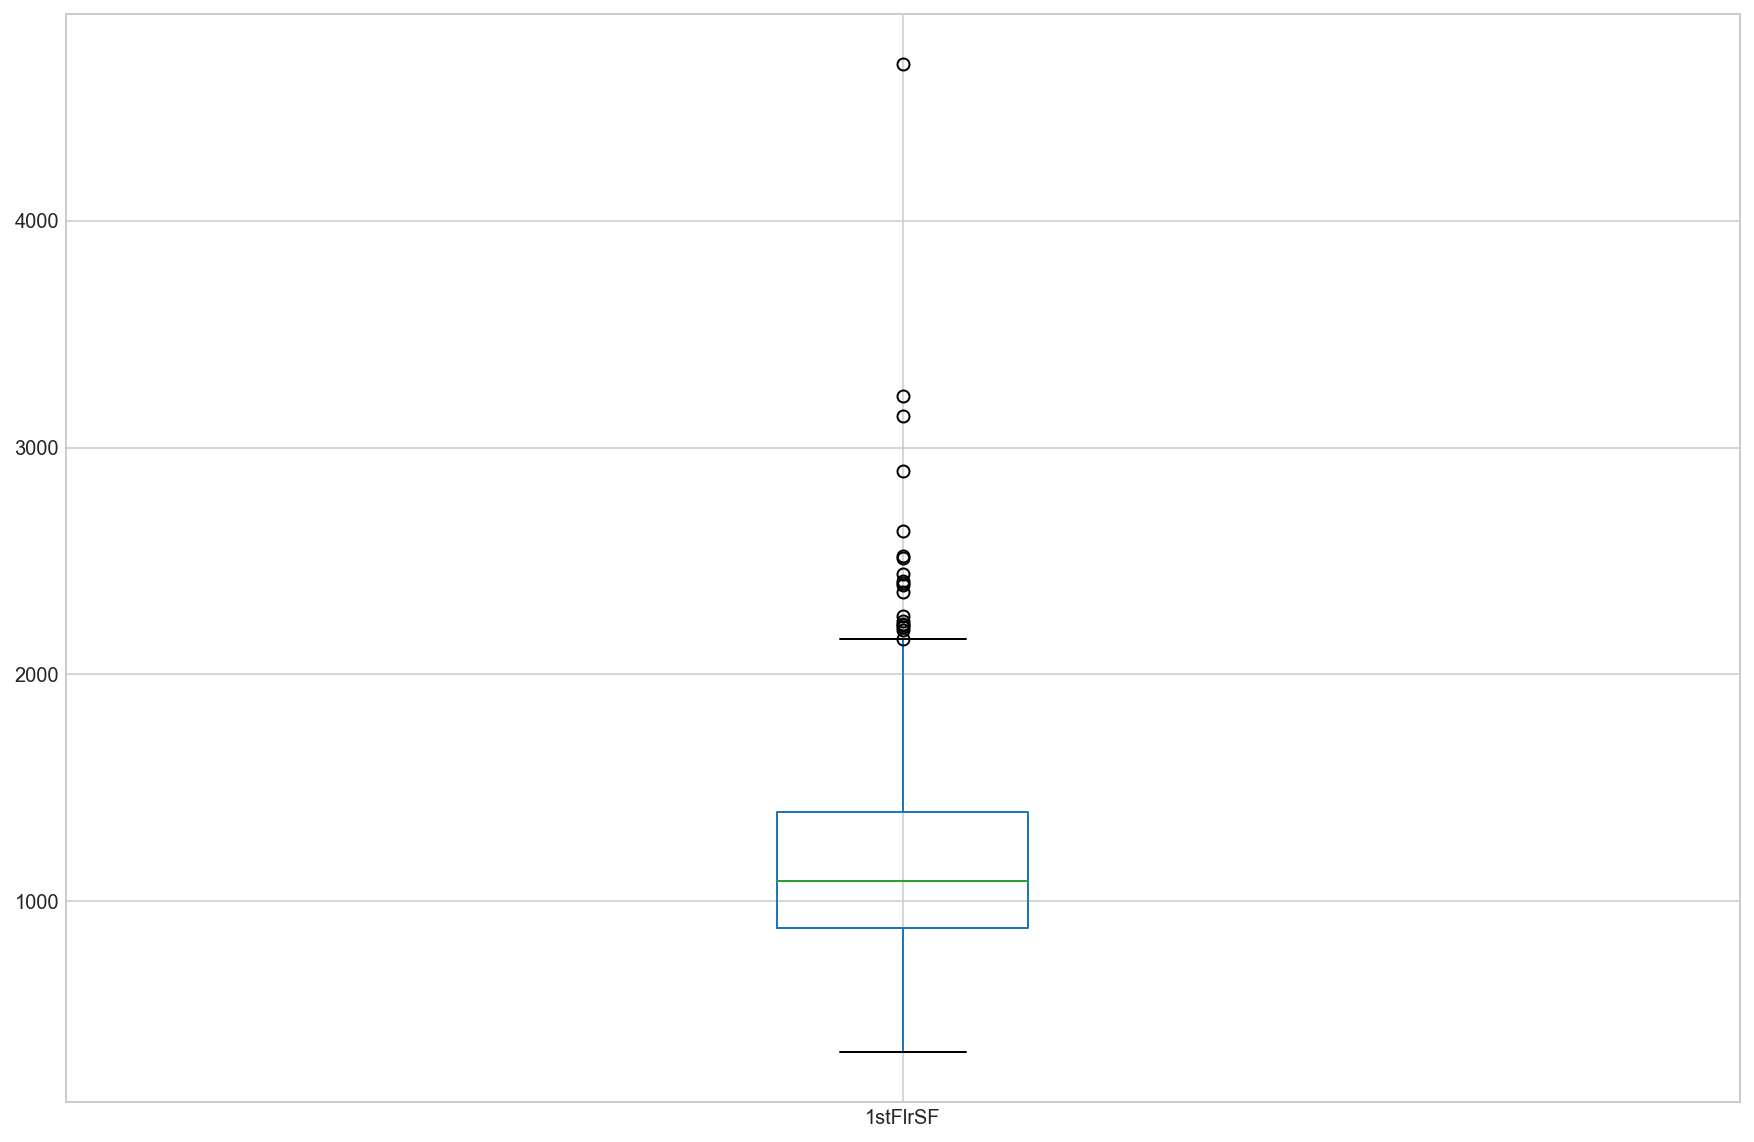

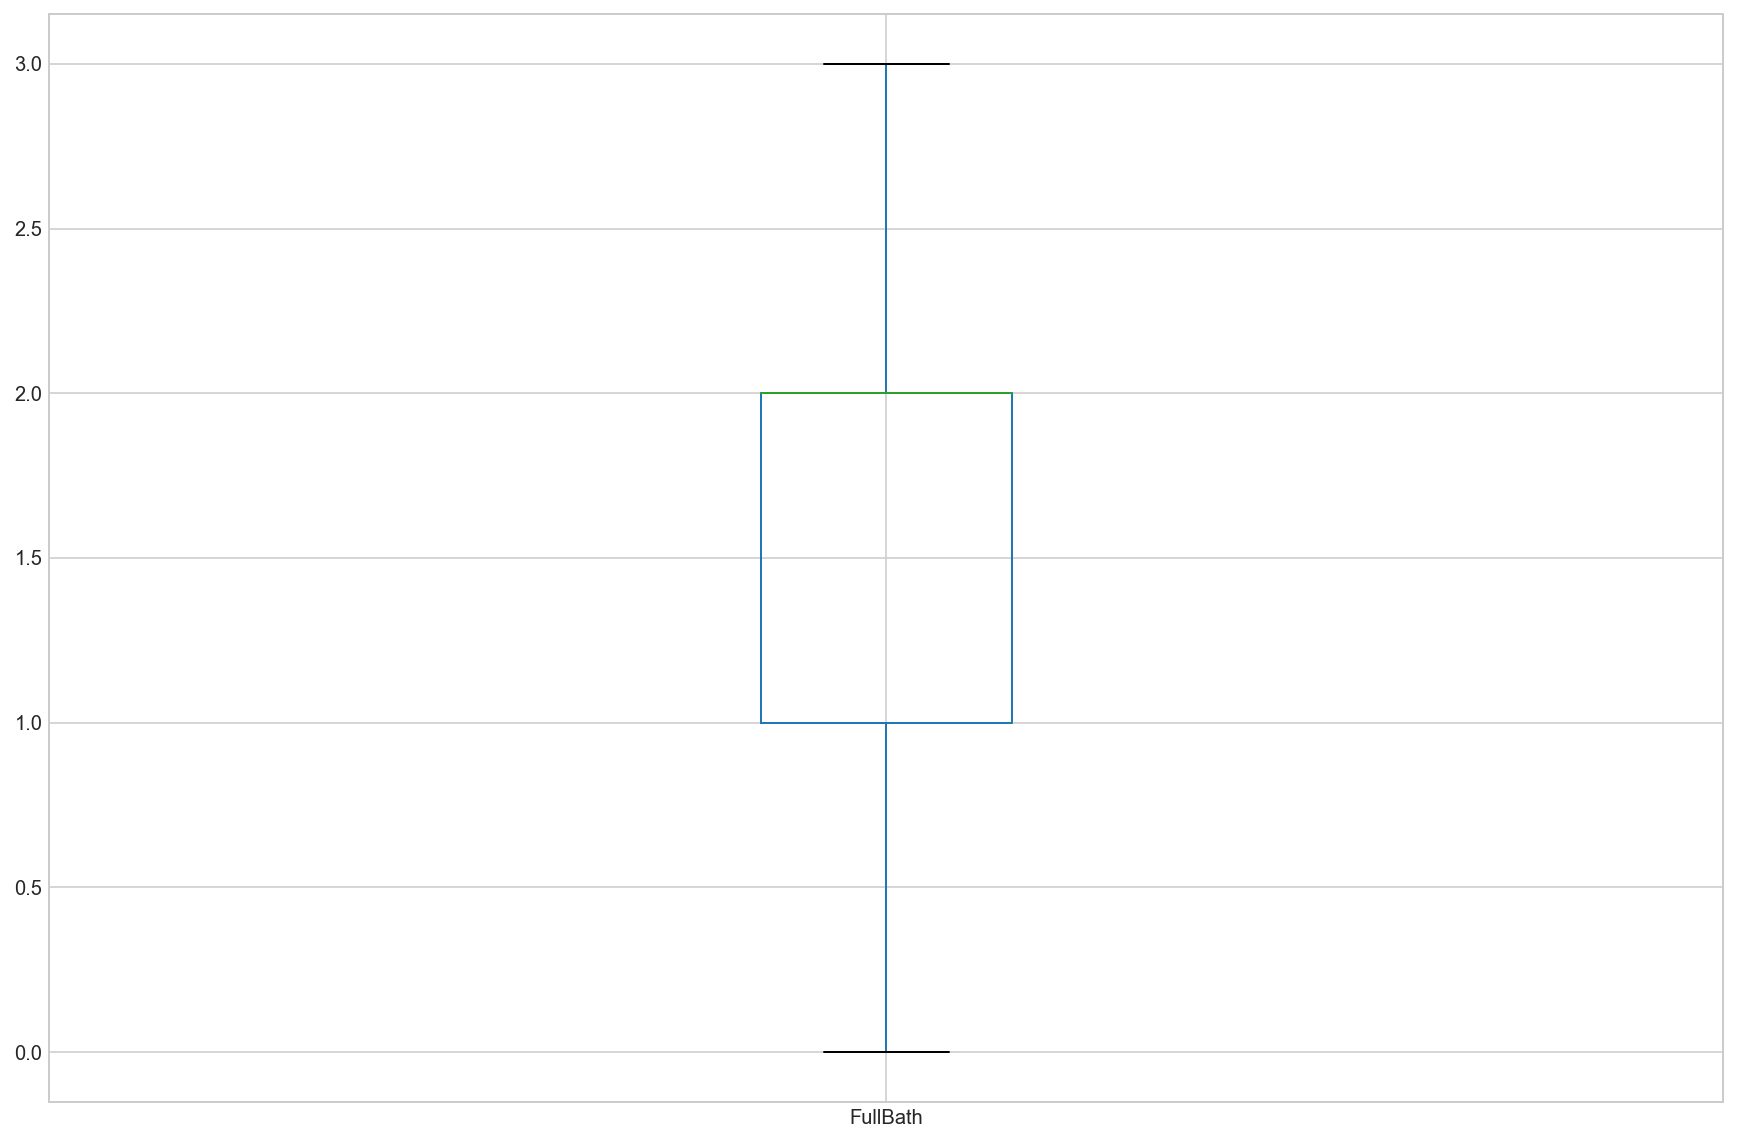

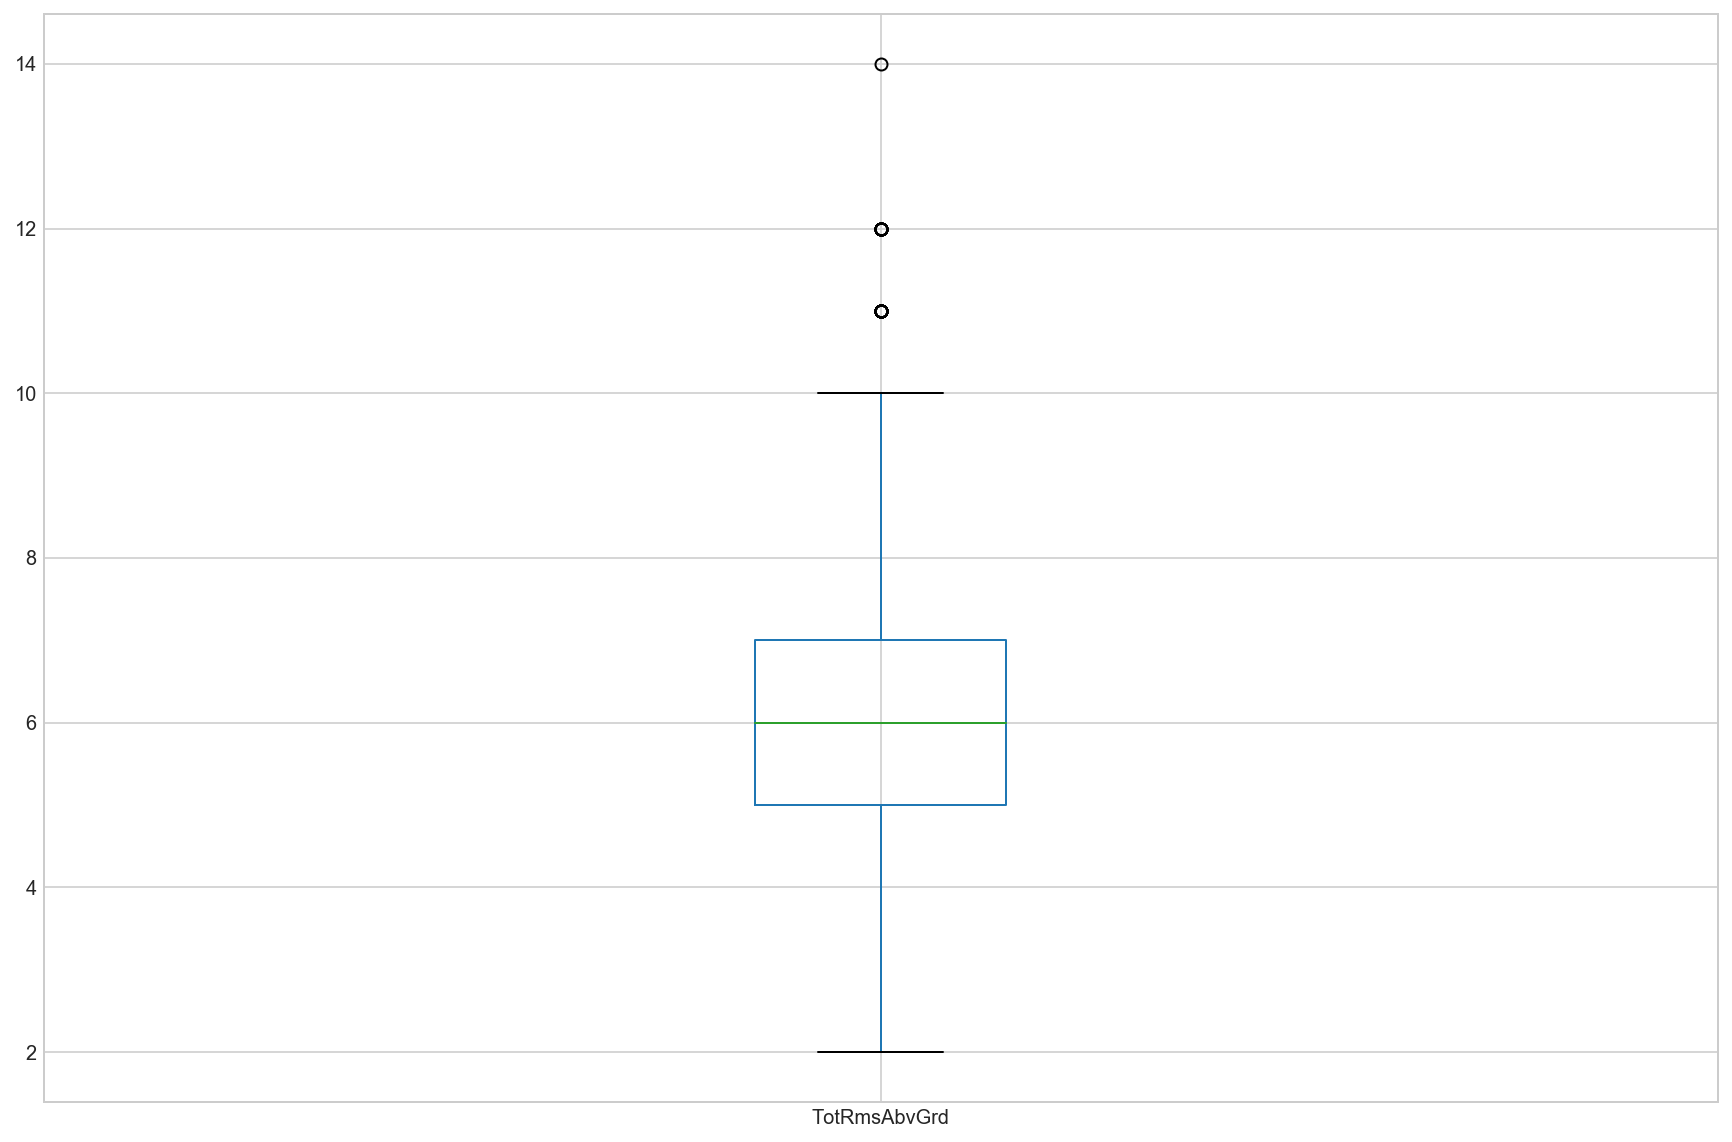

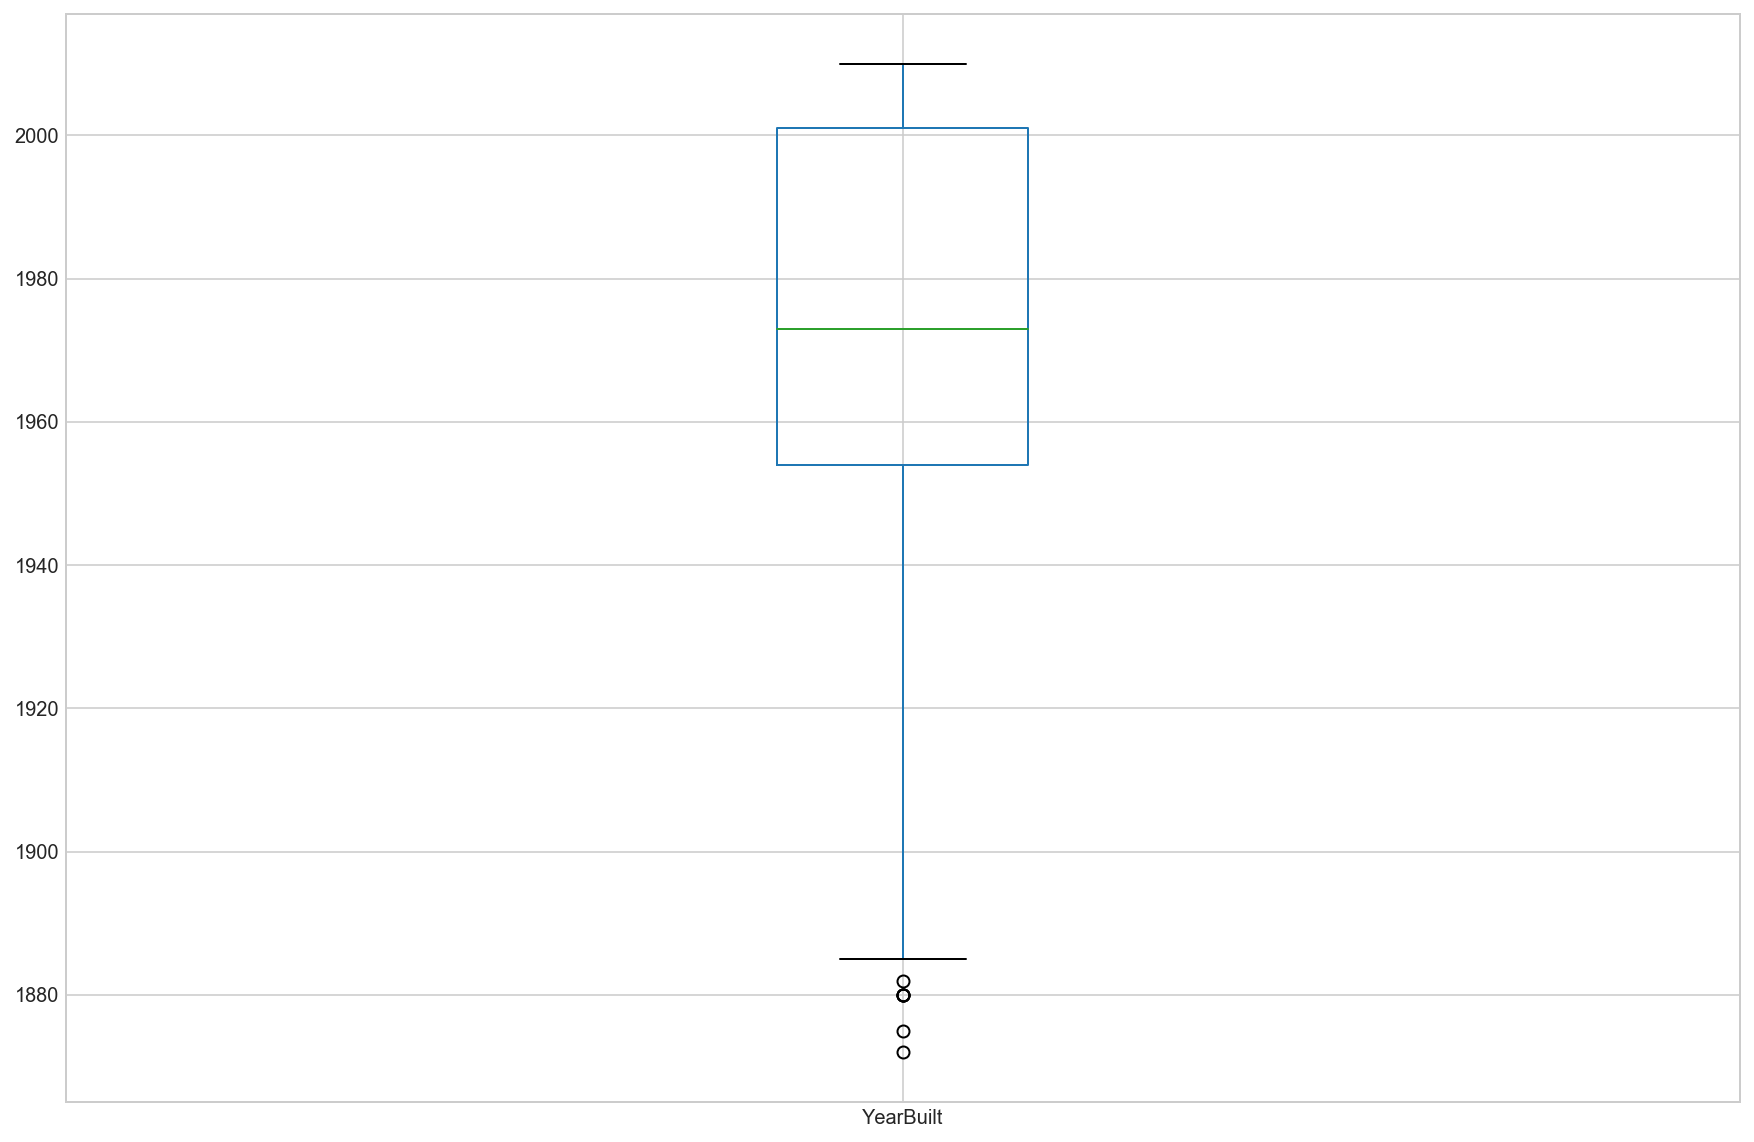

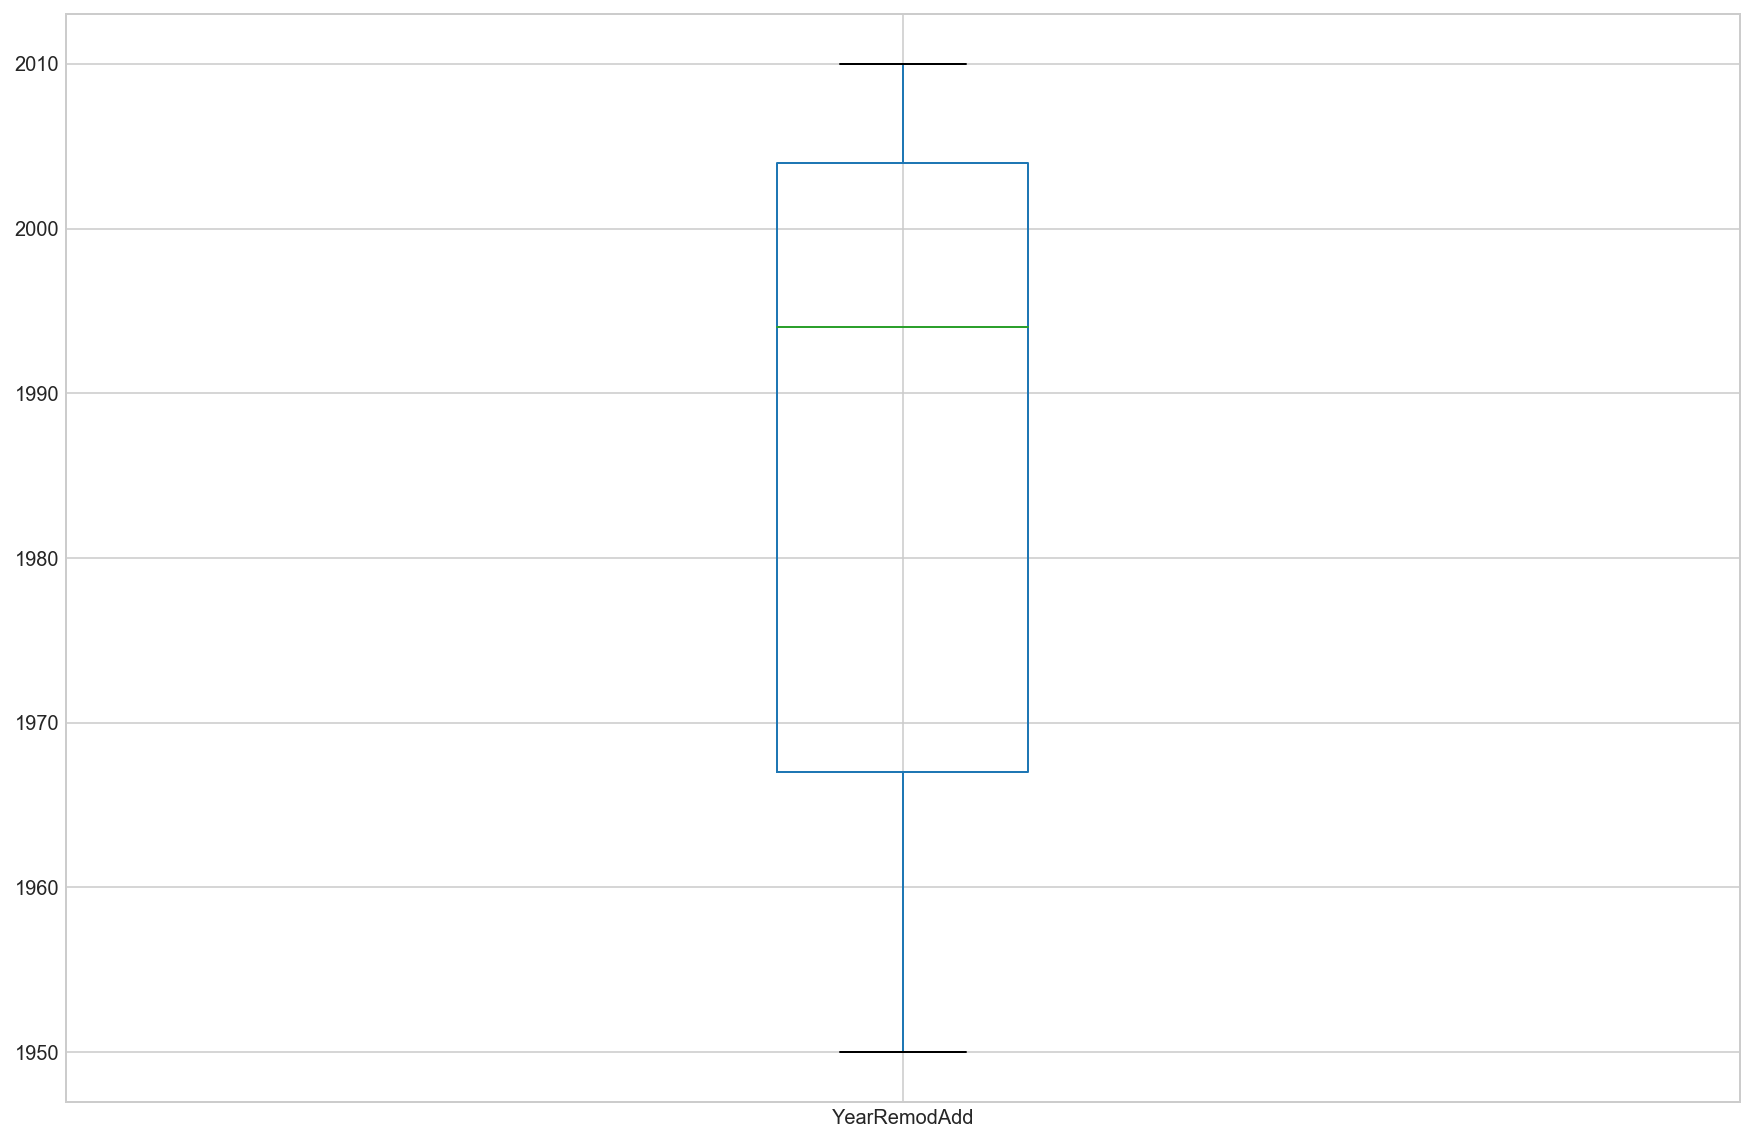

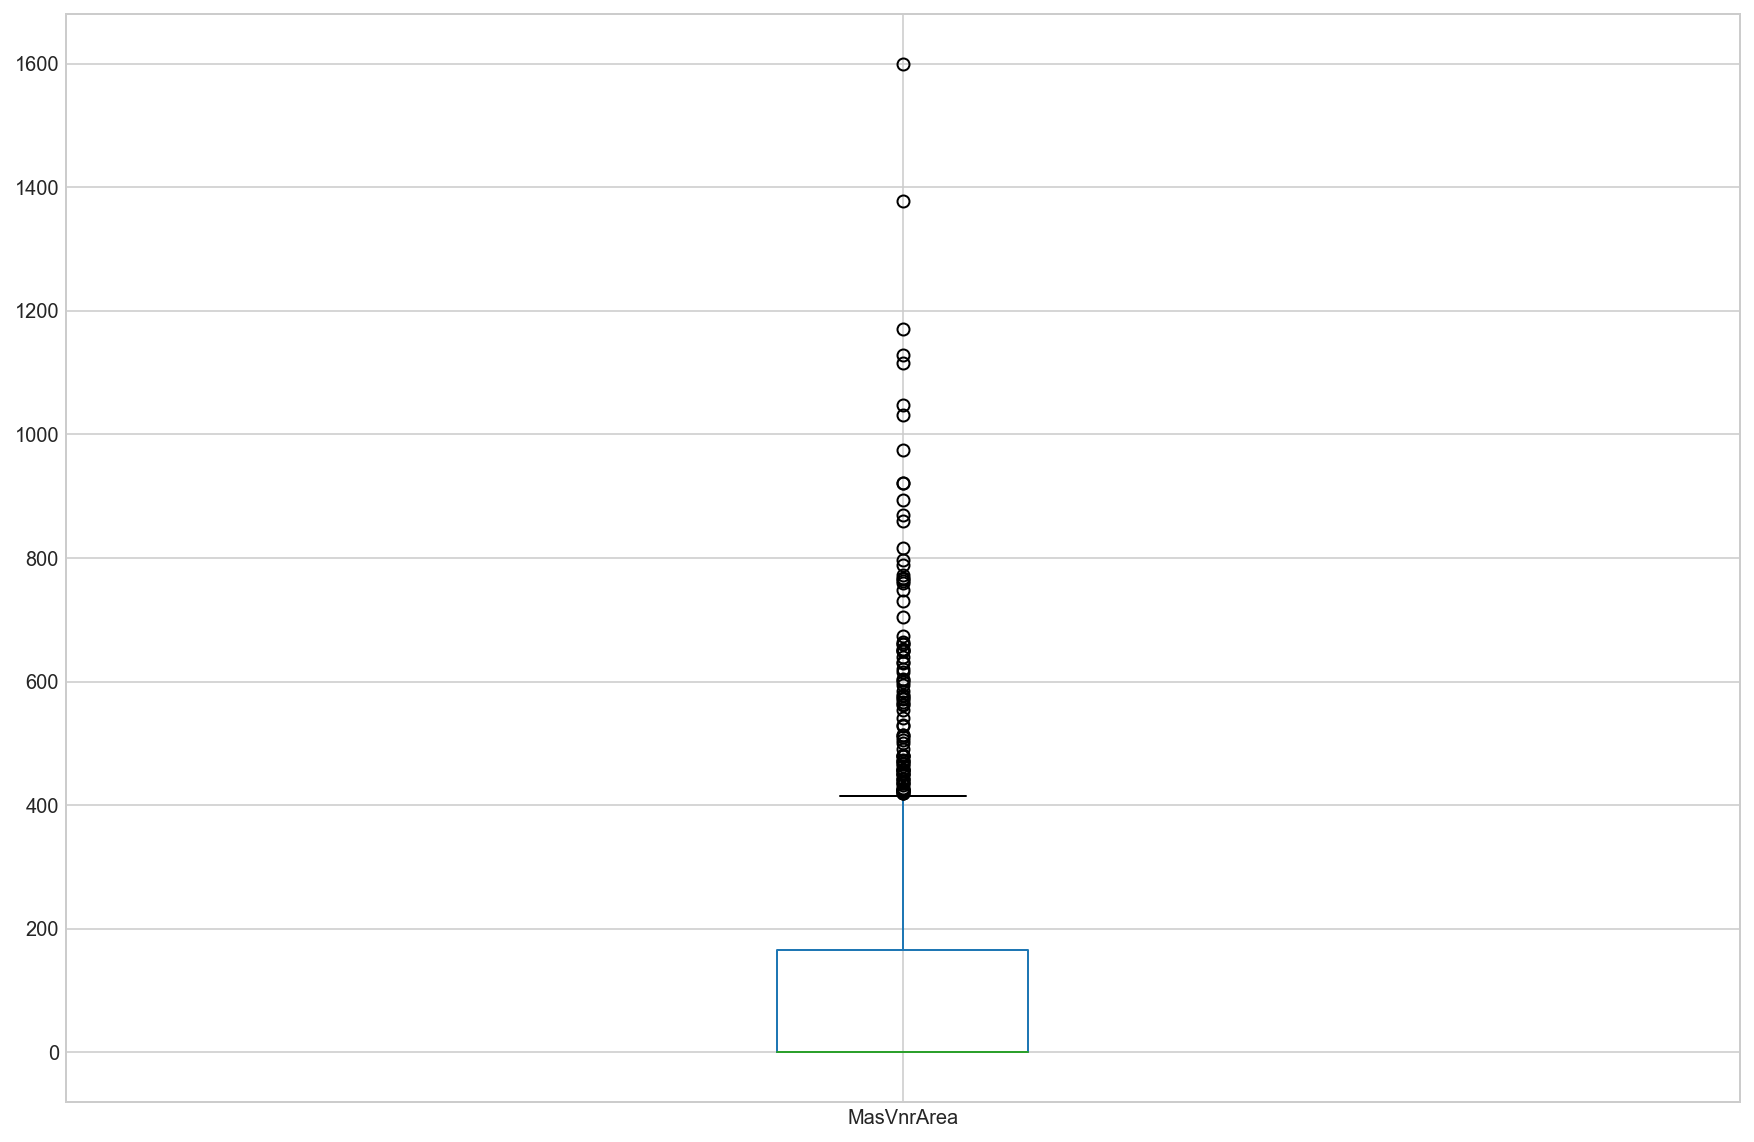

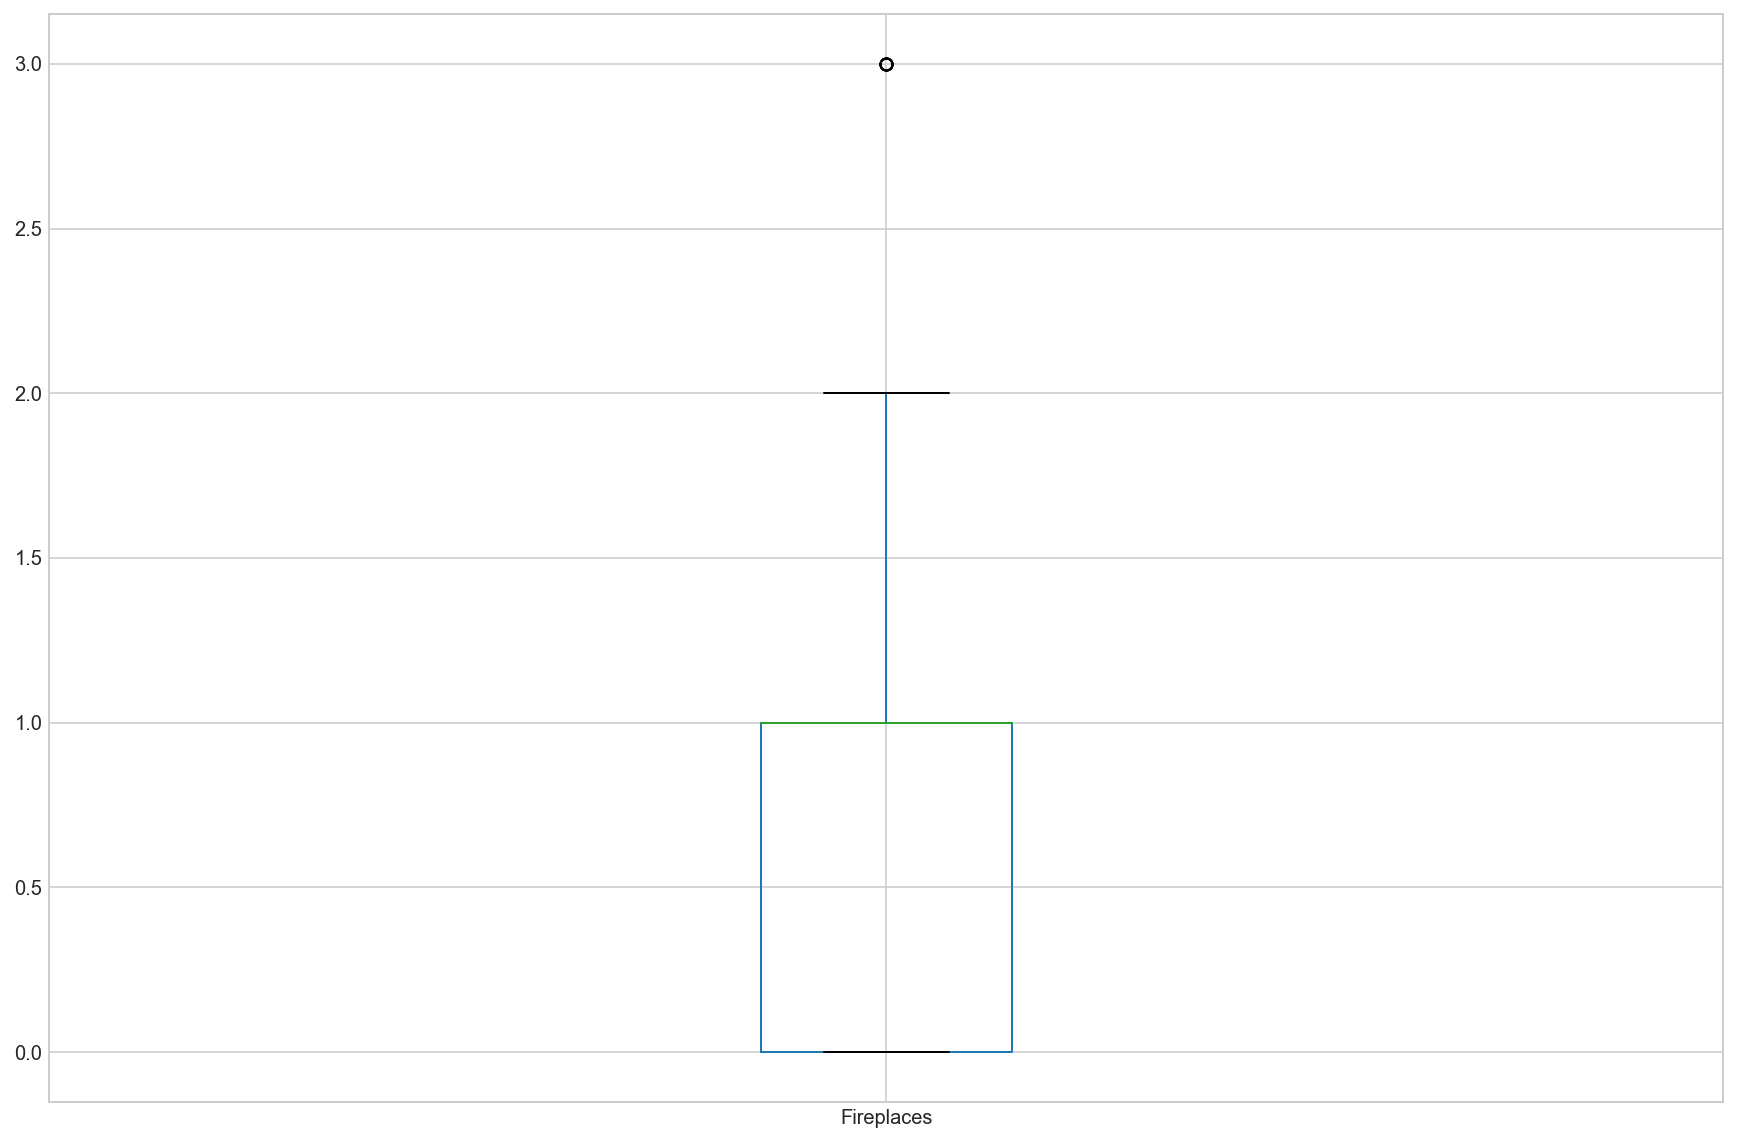

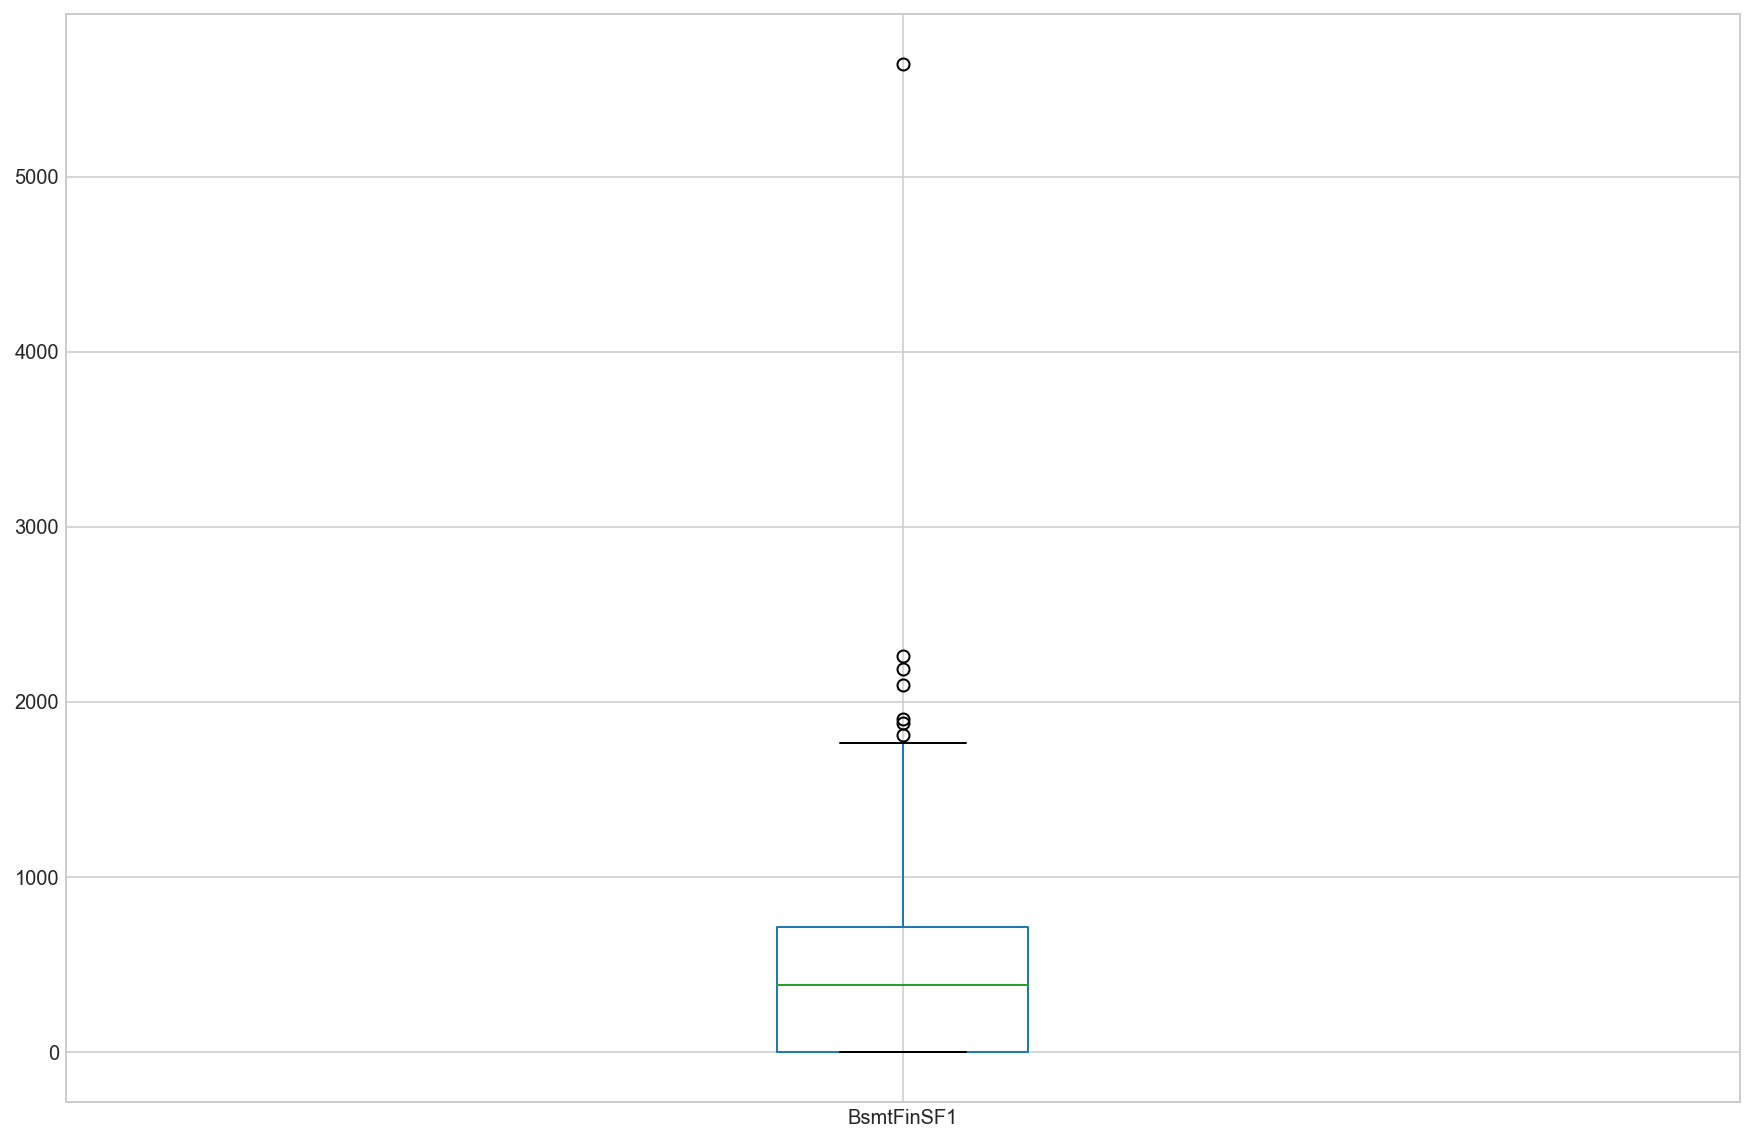

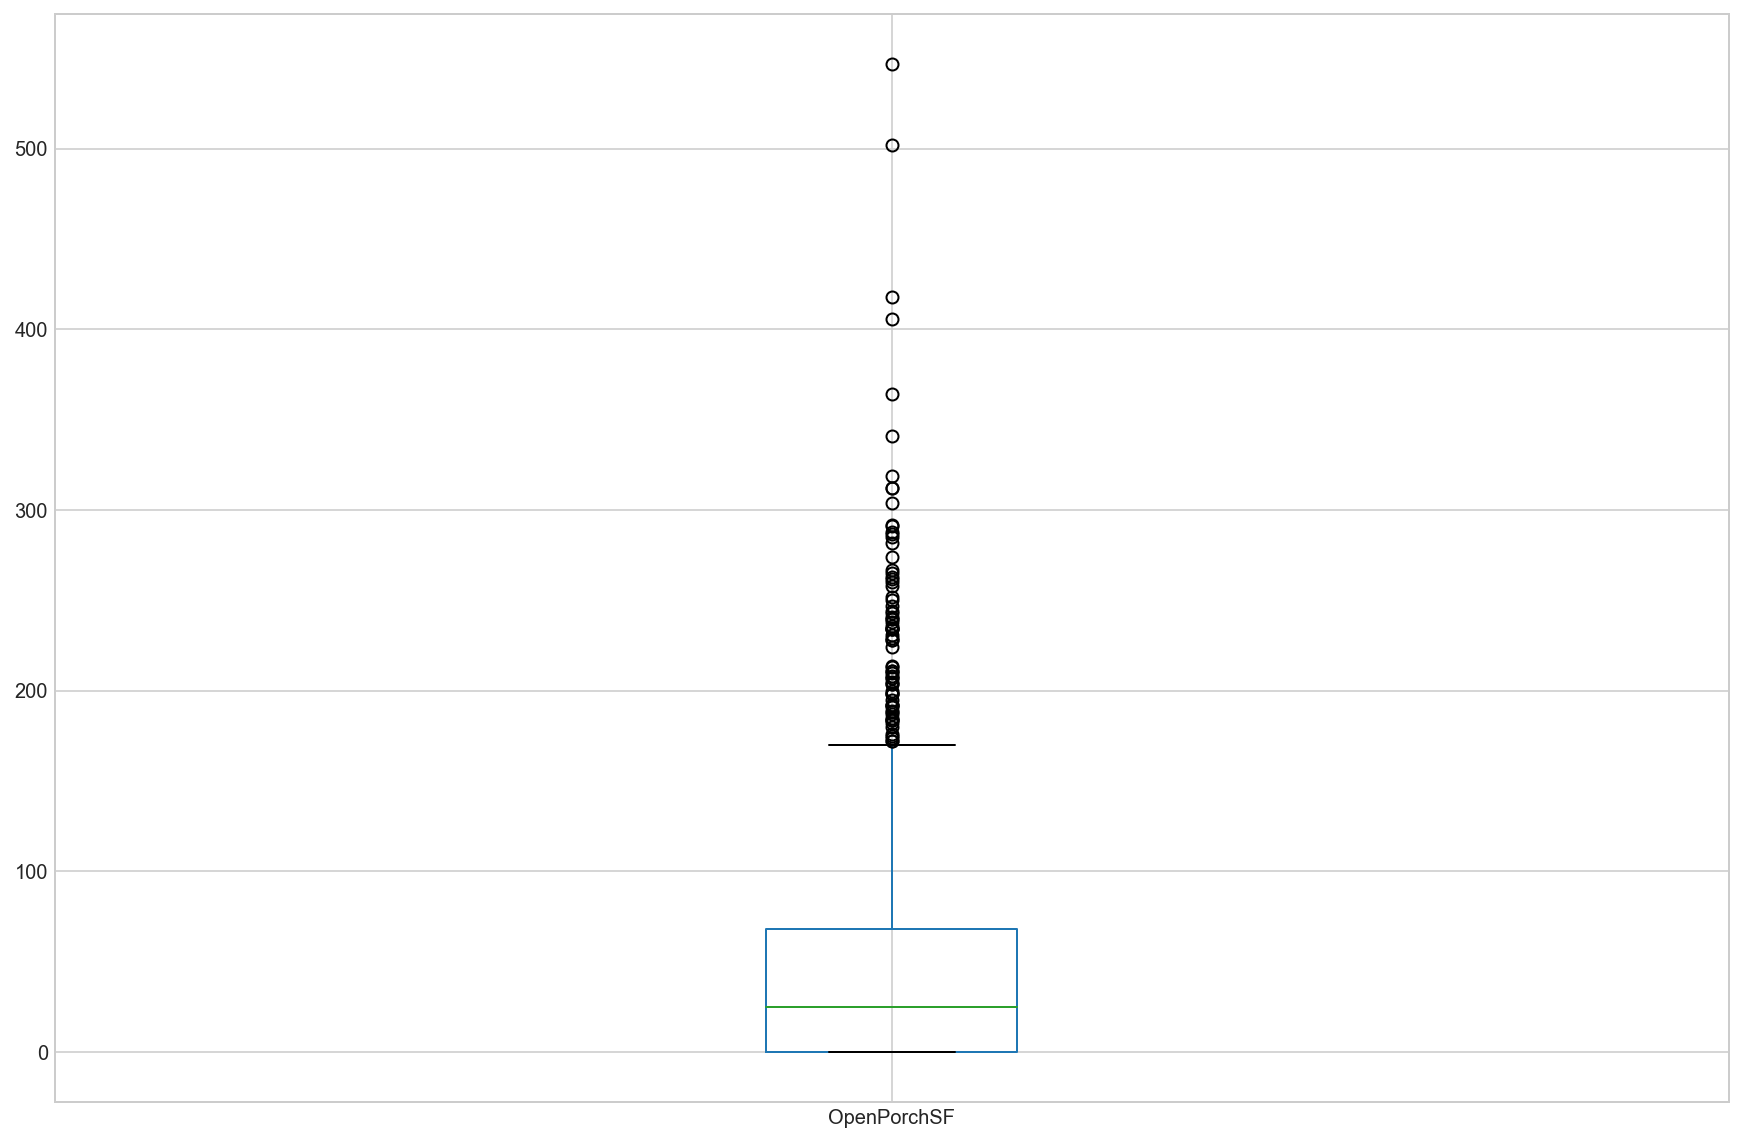

In [507]:
# # plot the boxplot for the top 15 features
# fig = plt.figure(figsize=(10,10))
# ax = fig.gca()

# for column in house_corr_saleprice_columns:
#     house[column].plot(kind='box', figsize=(15,10), legend=False)
#     plt.show()

In [508]:
house.shape

(1450, 81)

In [509]:
house.YrSold.value_counts().sort_index(ascending=False)

2010    172
2009    336
2008    302
2007    328
2006    312
Name: YrSold, dtype: int64

In [510]:
# drop the clear outliers as per visual inspection of the plots

# remove rows that has SalePrice above 600K 
house.drop(house[(house.SalePrice > 600000) & (house.YrSold < 2010)].index, inplace=True)

# remove rows that has OverallQual below 2 
house.drop(house[(house.OverallQual<2) & (house.YrSold < 2010)].index, inplace=True)

# remove rows that has GrLivArea above 4000
house.drop(house[(house.GrLivArea>4000) & (house.YrSold < 2010)].index, inplace=True)

# remove rows that has GarageCars above 3.5
house.drop(house[(house.GarageCars>3.5) & (house.YrSold < 2010)].index, inplace=True)

# remove rows that has GrLivArea above 1300
house.drop(house[(house.GarageArea>1300) & (house.YrSold < 2010)].index, inplace=True)

# remove rows that has TotalBsmtSF above 6000
house.drop(house[(house.TotalBsmtSF>6000) & (house.YrSold < 2010)].index, inplace=True)

# remove rows that has 1stFlrSF above 4000
house.drop(house[(house['1stFlrSF']>4000) & (house.YrSold < 2010)].index, inplace=True)

house.drop(house[(house.TotRmsAbvGrd>10) & (house.YrSold < 2010)].index, inplace=True)

house.drop(house[(house.YearBuilt<1880) & (house.YrSold < 2010)].index, inplace=True)

house.drop(house[(house.MasVnrArea>1300) & (house.YrSold < 2010)].index, inplace=True)

house.drop(house[(house.Fireplaces>2.5) & (house.YrSold < 2010)].index, inplace=True)

house.drop(house[(house.BsmtFinSF1>5000) & (house.YrSold < 2010)].index, inplace=True)

house.drop(house[(house.OpenPorchSF>400) & (house.YrSold < 2010)].index, inplace=True)


In [511]:
house.shape

(1407, 81)

In [512]:
house.YrSold.value_counts().sort_index(ascending=False)

2010    172
2009    323
2008    291
2007    316
2006    305
Name: YrSold, dtype: int64

In [513]:
house.shape

(1407, 81)

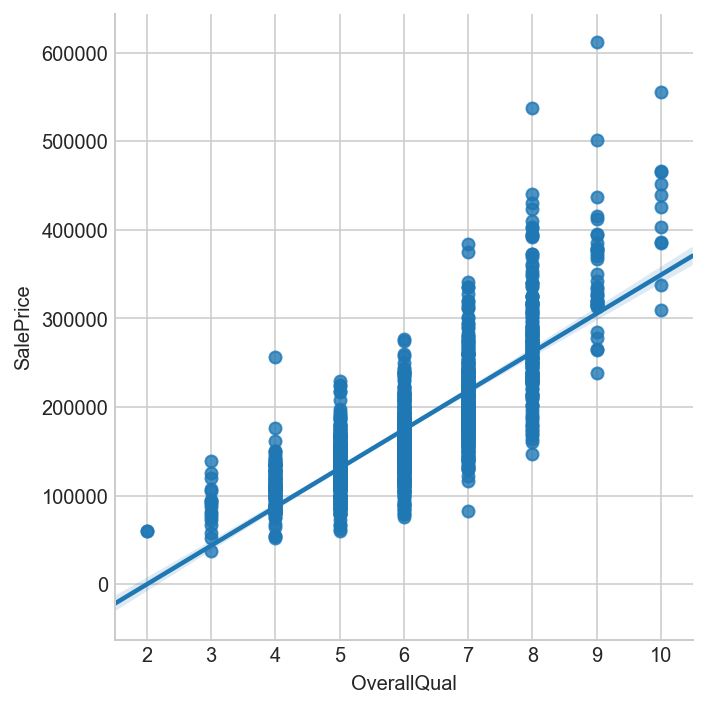

In [514]:
sns.lmplot('OverallQual', 'SalePrice', house)

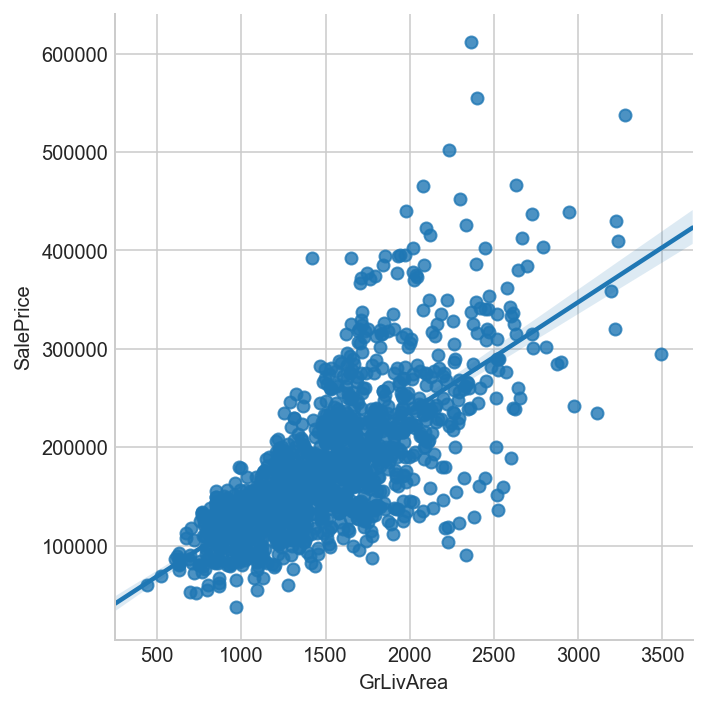

In [515]:
sns.lmplot('GrLivArea', 'SalePrice', house)

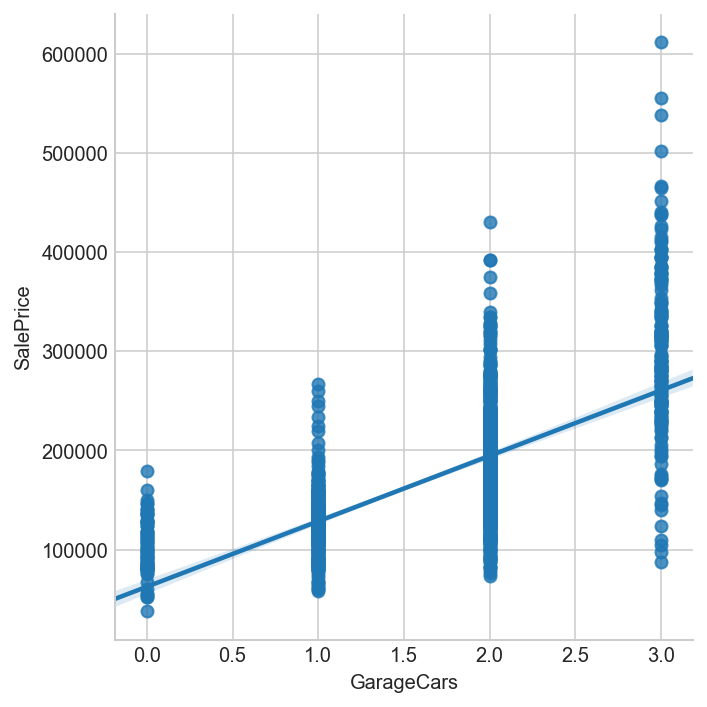

In [516]:
sns.lmplot('GarageCars', 'SalePrice', house)

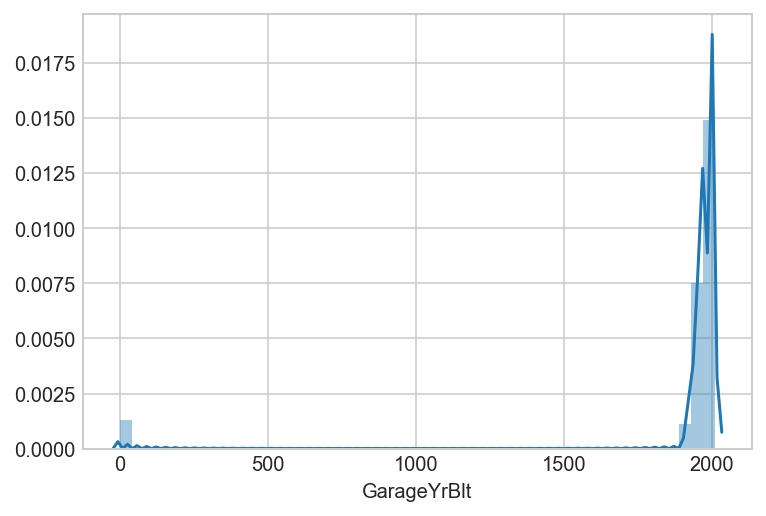

In [517]:
sns.distplot(house.GarageYrBlt)

### Fixed Features

In [518]:
# fixed features
fixed_features = ['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice']
house_ff = house[fixed_features]
house_ff.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,65.0,8450,Pave,No alley access,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,None,0,2,2008,WD,Normal,208500
1,20,80.0,9600,Pave,No alley access,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,None,0,5,2007,WD,Normal,181500
2,60,68.0,11250,Pave,No alley access,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,None,0,9,2008,WD,Normal,223500
3,70,60.0,9550,Pave,No alley access,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,None,0,2,2006,WD,Abnorml,140000
4,60,84.0,14260,Pave,No alley access,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,None,0,12,2008,WD,Normal,250000


In [519]:
# renovateable features
renovateable_features = ['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SalePrice']
house_rf = house[renovateable_features]
house_rf.head()

,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,BsmtCond,...,KitchenQual,Fireplaces,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,SalePrice
0,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,TA,...,Gd,0,No Fireplace,RFn,TA,TA,Y,No Pool,No Fence,208500
1,6,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,TA,...,TA,1,TA,RFn,TA,TA,Y,No Pool,No Fence,181500
2,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,TA,...,Gd,1,TA,RFn,TA,TA,Y,No Pool,No Fence,223500
3,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,Gd,...,Gd,1,Gd,Unf,TA,TA,Y,No Pool,No Fence,140000
4,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,TA,...,Gd,1,TA,RFn,TA,TA,Y,No Pool,No Fence,250000


In [520]:
def __dummy(df, category):
    import pandas as pd
    # dummify the categorical variable
    print(category)
    dummy = pd.get_dummies(df[category], prefix = str(category)) #str(category))

    # concatenate this to the original dataframe
    df = pd.concat([df, dummy], axis = 1)

    # delete the original categorical variable, 
    df.drop(columns = [category], inplace = True)

    # get the name of the last column in dummies, and delete the last column of dummified variable
    del_col = dummy.columns.values.tolist()[-1]
    df.drop(columns = [del_col], inplace = True)
    
    return df

def dummify(df, categorical_var = None):
    import numpy as np
    
    if categorical_var != None:
        # loop through each categorical variable
        for category in categorical_var:
            # dummify this category
            df = __dummy(df, category)

        return df
    else:
        variables = df.columns.values.tolist()
        
        cate_vars = []
        for var in variables:
            if np.issubdtype(df[var].dtype, np.number) == False:
                cate_vars.append(var)
        
        
        for category in cate_vars:
            # dummify this category
            df = __dummy(df, category)
            
        return df

In [521]:
# dummify house-fixed features dataframe
house_ff_dm = dummify(house_ff)

Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
Foundation
BsmtQual
BsmtExposure
Functional
GarageType
MiscFeature
SaleType
SaleCondition


In [524]:
# get top 15 features with highest correlation with SalePrice
house_ff_dm_corr_saleprice_columns = list(house_ff_dm.corrwith(house_ff_dm.SalePrice).sort_values(ascending=False).head(15).index)
house_ff_dm_corr_saleprice_columns

['SalePrice',
 'GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 'GarageArea',
 '1stFlrSF',
 'YearBuilt',
 'FullBath',
 'BsmtQual_Ex',
 'Foundation_PConc',
 'YearRemodAdd',
 'TotRmsAbvGrd',
 'MasVnrArea',
 'Neighborhood_NridgHt',
 'BsmtFinSF1']

Text(0.5,1,'Top 15 correlated features to Sale Price - Fixed Features Set')

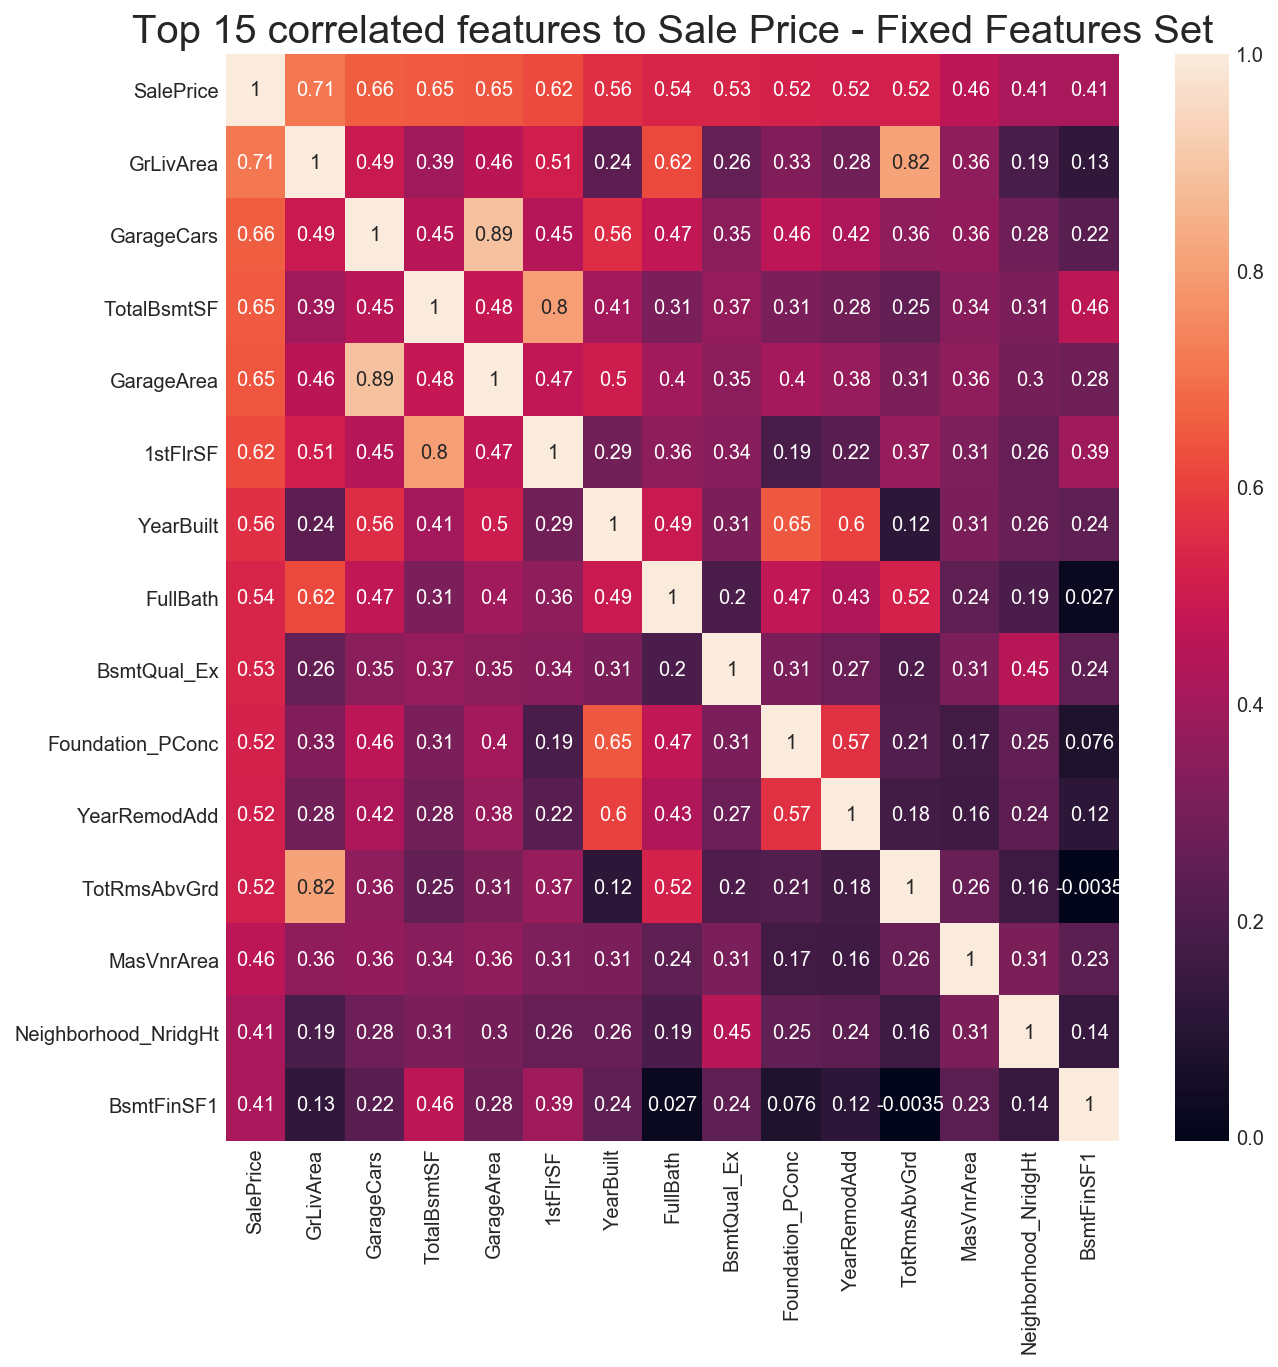

In [525]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()

sns.heatmap(house_ff_dm[house_ff_dm_corr_saleprice_columns].corr(), annot=True, ax=ax)

ax.set_title('Top 15 correlated features to Sale Price - Fixed Features Set', fontsize=20)

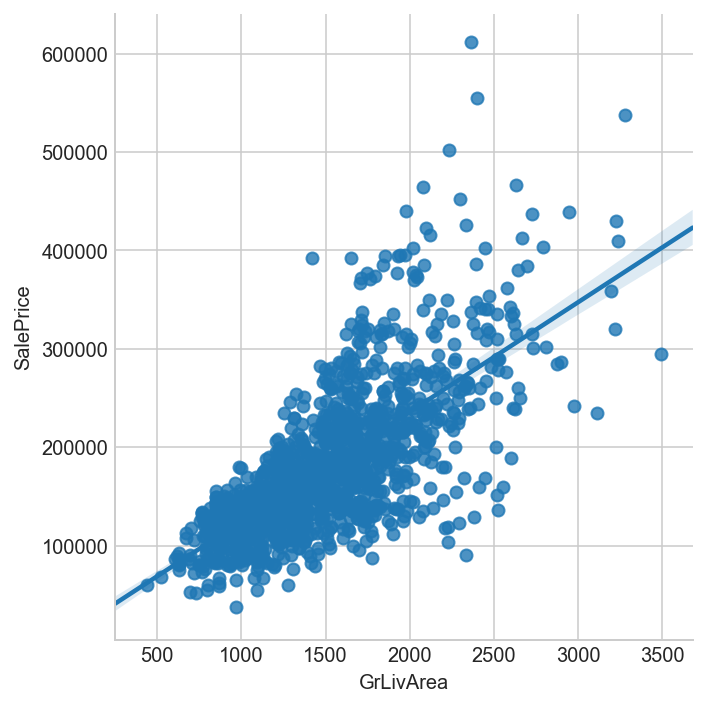

In [526]:
sns.lmplot('GrLivArea', 'SalePrice', house_ff_dm)

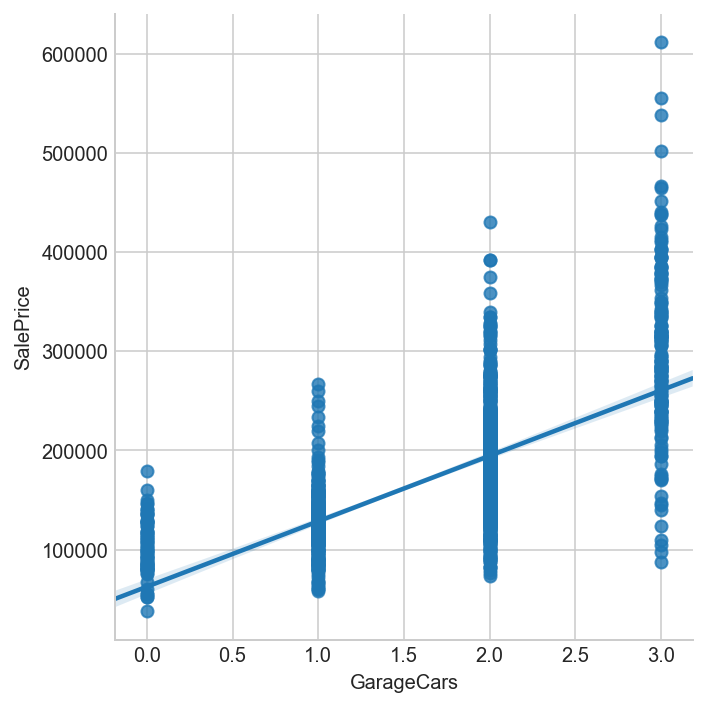

In [527]:
sns.lmplot('GarageCars', 'SalePrice', house_ff_dm)

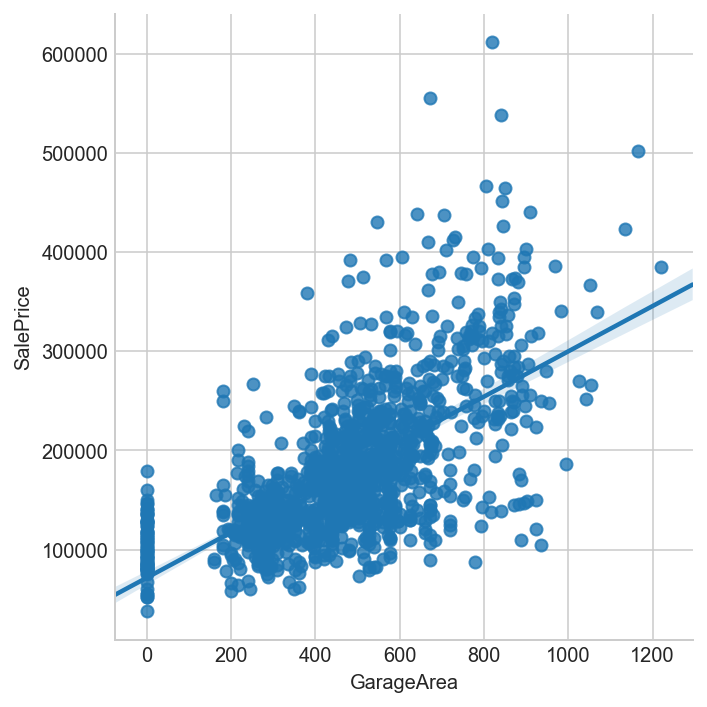

In [528]:
sns.lmplot('GarageArea', 'SalePrice', house_ff_dm)

In [529]:
house_ff_dm.YrSold.value_counts().sort_index()

2006    305
2007    316
2008    291
2009    323
2010    172
Name: YrSold, dtype: int64

### Split data for Fixed Features - 2010 rows and pre-2010 rows

In [530]:
# split the dataset into 2: those with YrSold=2010, and those with YrSold < 2010 
house_ff_2010 = house_ff_dm[house_ff_dm.YrSold == 2010]
house_ff_pre2010 = house_ff_dm[house_ff_dm.YrSold < 2010]

# get top 15 features with highest correlation with SalePrice
house_ff_dm_corr_saleprice_columns = list(house_ff_dm.corrwith(house_ff_dm.SalePrice).sort_values(ascending=False).head(15).index)
house_ff_dm_corr_saleprice_columns

['SalePrice',
 'GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 'GarageArea',
 '1stFlrSF',
 'YearBuilt',
 'FullBath',
 'BsmtQual_Ex',
 'Foundation_PConc',
 'YearRemodAdd',
 'TotRmsAbvGrd',
 'MasVnrArea',
 'Neighborhood_NridgHt',
 'BsmtFinSF1']

In [531]:
# print the shape of the 2010 and pre-2010 data sets
print(house_ff_pre2010.shape)
print(house_ff_2010.shape)

(1235, 139)
(172, 139)


### Standardize, Split Data into Train, Dev, Test

In [1351]:
# set feature X and label y columns for the pre-2010 dataset
X_pre_2010 = house_ff_pre2010.loc[:, house_ff_pre2010.columns != 'SalePrice']
y_pre_2010 = house_ff_pre2010['SalePrice']

# set feature X and label y columns for the 2010 dataset
X_test = house_ff_2010.loc[:, house_ff_2010.columns != 'SalePrice']
y_test = house_ff_2010['SalePrice']

# standardize pre-2010 data
ss = StandardScaler()
Xs_pre_2010 = ss.fit_transform(X_pre_2010)
Xs_pre_2010 = pd.DataFrame(Xs_pre_2010, columns=X_pre_2010.columns, index=list(X_pre_2010.index))

# standardize 2010 data
Xs_test = ss.transform(X_test)
Xs_test = pd.DataFrame(Xs_test, columns=X_test.columns, index=list(X_test.index))

# split pre-2010 data into train and dev sets
X, X_dev, y, y_dev = train_test_split(Xs_pre_2010, y_pre_2010, test_size=0.20)

### Baseline

In [1352]:
# get baseline mean on pre-2010 dataset
baseline_ff = np.mean(y)
baseline_ff

177309.03441295546

### Feature Selection

### SelectKBest - f_regression and mutual_info_regression

In [1353]:
#f_regression
skb_fr = SelectKBest(f_regression, k=X.shape[1])
#mutual_info_regression
skb_mr = SelectKBest(mutual_info_regression, k=X.shape[1])

# train the selector on our data
skb_fr.fit(X, y)
skb_mr.fit(X, y)

# examine results
kbest = pd.DataFrame([X_pre_2010.columns, list(skb_fr.scores_), list(skb_mr.scores_)], 
                     index=['feature','f_regression', 'mutual_info_regression']).T.sort_values('f_regression', ascending=False)
kbest.head(10)

,feature,f_regression,mutual_info_regression
13,GrLivArea,986.268,0.440663
22,GarageCars,782.372,0.358933
9,TotalBsmtSF,756.676,0.38383
23,GarageArea,716.396,0.3771
10,1stFlrSF,631.677,0.316404
3,YearBuilt,464.218,0.3746
102,BsmtQual_Ex,421.227,0.11999
16,FullBath,400.503,0.250267
4,YearRemodAdd,379.523,0.249958
99,Foundation_PConc,346.197,0.178305


### Tuning SelectKBest (f_regression) through incremental cross validation of selected features

This section lets you refine the results from the SelectKBest operation by returning the optimal set of features that produce the highest cross validation mean score. This is done by incrementally expanding the feature set based on the ordered list of features obtained through the SelectKBest function. 

In [1354]:
# print BEST SelectKBest score for f_regression (based on cumulative ranking, using cross_val_score)
top_columns_list=[]
mean_score_for_top_columns = []
for key,n_top_columns in kbest['feature'].iteritems():
    top_columns_list.append(n_top_columns)
    
    # cross validate with linear regression
    lr = LinearRegression()
    mean_score = cross_val_score(lr, X[top_columns_list], y, cv=10).mean()
    mean_score_for_top_columns.append(mean_score)

# append cumulative mean score to the kbest dataframe as a new column
kbest['cumulative_mean_score'] = mean_score_for_top_columns    

In [1355]:
# select the best set of features - the one that yielded the highest cross validation mean score
kbest_f_regression_top_mean_score = kbest['cumulative_mean_score'].max()
kbest_last_top_feature = kbest[kbest['cumulative_mean_score'] == kbest_f_regression_top_mean_score]
index = kbest['cumulative_mean_score'].tolist().index(kbest_f_regression_top_mean_score)
kbest_f_regression_columns = kbest['feature'][:index+1].tolist()

In [1356]:
# print the top cross validation mean score as well as the corresponding top feature set
print('SelectKBest top mean score (f_regression): \n\n', kbest_f_regression_top_mean_score, '\n')
print('SelectKBest top columns list (f_regression): \n\n', kbest_f_regression_columns, '\n')

SelectKBest top mean score (f_regression): 

 0.8778622384812651 

SelectKBest top columns list (f_regression): 

 ['GrLivArea', 'GarageCars', 'TotalBsmtSF', 'GarageArea', '1stFlrSF', 'YearBuilt', 'BsmtQual_Ex', 'FullBath', 'YearRemodAdd', 'Foundation_PConc', 'TotRmsAbvGrd', 'MasVnrArea', 'Neighborhood_NridgHt', 'BsmtFinSF1', 'GarageType_Attchd', 'GarageType_Detchd', 'OpenPorchSF', 'WoodDeckSF', 'Foundation_CBlock', 'SaleType_New', 'BsmtExposure_Gd', 'BsmtQual_Gd', 'Neighborhood_NoRidge', 'BsmtFullBath', 'GarageYrBlt', 'HalfBath', 'BsmtExposure_No', 'LotArea', 'Neighborhood_OldTown', 'Foundation_BrkTil', '2ndFlrSF', 'HouseStyle_2Story', 'Neighborhood_StoneBr', 'Neighborhood_NAmes', 'BsmtUnfSF', 'LotShape_IR1', 'HouseStyle_1.5Fin', 'LotFrontage', 'Neighborhood_Edwards', 'Neighborhood_Somerst', 'Neighborhood_Timber', 'GarageType_BuiltIn', 'BsmtQual_No Basement', 'Alley_Grvl', 'KitchenAbvGr', 'EnclosedPorch', 'BldgType_1Fam', 'Neighborhood_IDOTRR', 'SaleCondition_Normal', 'Condition1_Arte

In [1357]:
# no. of top columns with the highest cross val mean score 
len(kbest_f_regression_columns)

78

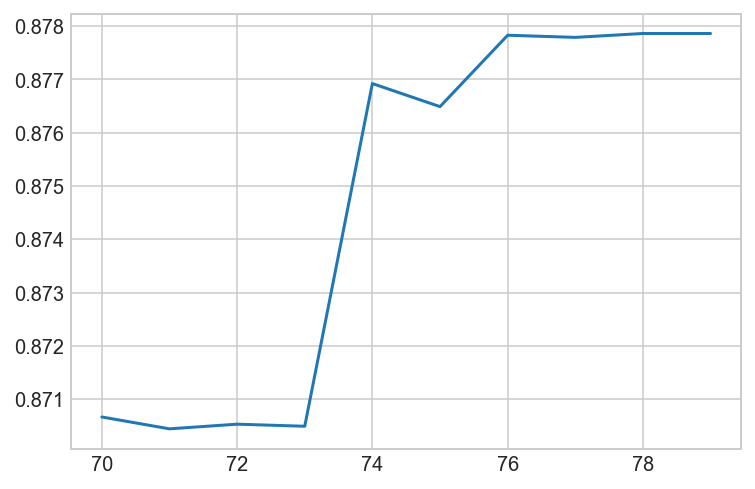

In [1362]:
# plot the mean_scores of the top-n features selected through SelectKBest method
plt.plot(np.arange(70, 80),mean_score_for_top_columns[69:79])
#plt.plot(np.arange(1, len(mean_score_for_top_columns)+1),mean_score_for_top_columns[0:len(mean_score_for_top_columns)])

### Tuning SelectKBest (mutual_info_regression) through incremental cross validation of selected features

This section lets you refine the results from the SelectKBest operation by returning the optimal set of features that produce the highest cross validation mean score. This is done by incrementally expanding the feature set based on the ordered list of features obtained through the SelectKBest function. 

In [1363]:
# sort the features based on mutual_info_regression scores
kbest_mr = kbest.sort_values('mutual_info_regression', ascending=False)

In [1364]:
# print BEST SelectKBest score using mutual_info_regression (based on cumulative ranking, using cross_val_score)
top_columns_list=[]
mean_score_for_top_columns = []
for key,n_top_columns in kbest_mr['feature'].iteritems():
    top_columns_list.append(n_top_columns)
    
    # cross validate with linear regression
    lr = LinearRegression()
    mean_score = cross_val_score(lr, X[top_columns_list], y, cv=10).mean()
    mean_score_for_top_columns.append(mean_score)

# append cumulative mean score to the kbest_mr dataframe as a new column
kbest_mr['cumulative_mean_score'] = mean_score_for_top_columns    

In [1365]:
# select the best set of features - the one that yielded the highest cross validation mean score
kbest_mutual_regression_top_mean_score = kbest_mr['cumulative_mean_score'].max()
kbest_last_top_feature = kbest_mr[kbest_mr['cumulative_mean_score'] == kbest_mutual_regression_top_mean_score]
index = kbest_mr['cumulative_mean_score'].tolist().index(kbest_mutual_regression_top_mean_score)
kbest_mutual_regression_columns = kbest['feature'][:index+1].tolist()

In [1366]:
# print the top cross validation mean score as well as the corresponding top feature set
print('SelectKBest top mean score (mutual_info_regression): \n\n', kbest_mutual_regression_top_mean_score, '\n')
print('SelectKBest top columns list (mutual_info_regression): \n\n', kbest_mutual_regression_columns, '\n')

SelectKBest top mean score (mutual_info_regression): 

 0.8816825471672611 

SelectKBest top columns list (mutual_info_regression): 

 ['GrLivArea', 'GarageCars', 'TotalBsmtSF', 'GarageArea', '1stFlrSF', 'YearBuilt', 'BsmtQual_Ex', 'FullBath', 'YearRemodAdd', 'Foundation_PConc', 'TotRmsAbvGrd', 'MasVnrArea', 'Neighborhood_NridgHt', 'BsmtFinSF1', 'GarageType_Attchd', 'GarageType_Detchd', 'OpenPorchSF', 'WoodDeckSF', 'Foundation_CBlock', 'SaleType_New', 'BsmtExposure_Gd', 'BsmtQual_Gd', 'Neighborhood_NoRidge', 'BsmtFullBath', 'GarageYrBlt', 'HalfBath', 'BsmtExposure_No', 'LotArea', 'Neighborhood_OldTown', 'Foundation_BrkTil', '2ndFlrSF', 'HouseStyle_2Story', 'Neighborhood_StoneBr', 'Neighborhood_NAmes', 'BsmtUnfSF', 'LotShape_IR1', 'HouseStyle_1.5Fin', 'LotFrontage', 'Neighborhood_Edwards', 'Neighborhood_Somerst', 'Neighborhood_Timber', 'GarageType_BuiltIn', 'BsmtQual_No Basement', 'Alley_Grvl', 'KitchenAbvGr', 'EnclosedPorch', 'BldgType_1Fam', 'Neighborhood_IDOTRR', 'SaleCondition_Norma

In [1367]:
# no. of top columns with the highest cross val mean score 
len(kbest_mutual_regression_columns)

59

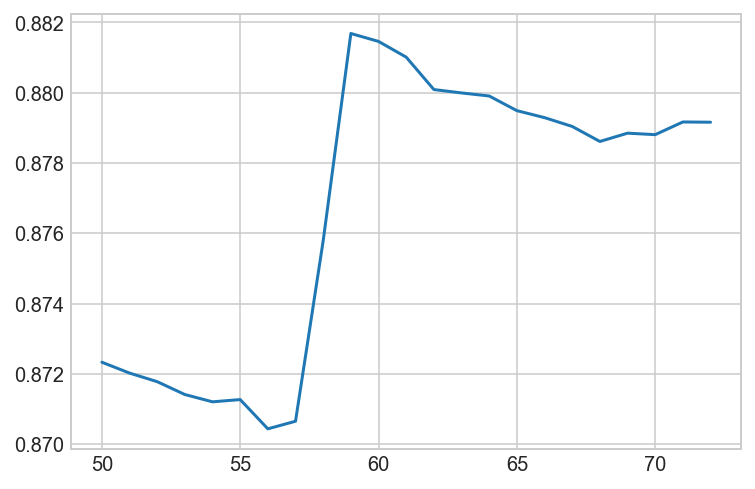

In [1369]:
# plot the mean_scores of the top-n features selected through SelectKBest (mutual_info_regression) method
plt.plot(np.arange(50, 73),mean_score_for_top_columns[49:72])

### RFECV - Feature Elimination

In [1370]:
# RFECV - Feature Elimination
lr = LinearRegression()
selector = RFECV(lr, step=1, cv=10)
selector = selector.fit(X, y)

In [1371]:
# print RFECV statistics
print('order or column rankings: \n', selector.ranking_, '\n')
print('number of columns with rank=1 : ', sum(selector.support_), '\n')
print('columns with rank=1:\n')
rfecv_columns = np.array(X.columns)[selector.support_]
print(rfecv_columns)

order or column rankings: 
 [ 17 103   1   1   1  75   1  20  21   1   1   1  22   1  73 107 108  33
   1  36  35   1   1  34  49  72  89  57  38  56  59  90 100  50  95 105
 112  82  93  91  37  48  70  88  31  51  69   1   1  46 109  52  13  12
   8  97   4   9  14  40   3   5  98   7  47   1   2  15   6  10  96   1
  11  54  39  77  83  81  32  78  28 106  94  85 101 111   1  16  76  71
  24  86  18  58  99  23  92  43  44  19  63  61   1  68  74   1  65   1
  67  66  30  41  25  42  53  26   1   1   1   1   1   1  60 104  84  45
  55  62  87 102 114  27 113  80  64 110  79  29] 

number of columns with rank=1 :  25 

columns with rank=1:

['LotArea' 'YearBuilt' 'YearRemodAdd' 'BsmtFinSF1' 'TotalBsmtSF'
 '1stFlrSF' '2ndFlrSF' 'GrLivArea' 'BedroomAbvGr' 'GarageYrBlt'
 'GarageCars' 'LandSlope_Gtl' 'LandSlope_Mod' 'Neighborhood_NridgHt'
 'Neighborhood_StoneBr' 'BldgType_1Fam' 'BsmtQual_Ex'
 'BsmtQual_No Basement' 'BsmtExposure_Gd' 'GarageType_2Types'
 'GarageType_Attchd' 'GarageType_Ba

### Tuning RFECV through incremental cross validation of ranking-ordered features 

This section lets you refine the results from the RFECV operation by returning the optimal set of features that produce the highest cross validation mean score. This is done by incrementally expanding the feature set based on the ranking-ordered list of features obtained through the RFECV function. 

In [1372]:
# print BEST RFECV score (based on cumulative ranking, using cross_val_score)
rank_min = selector.ranking_.min()
rank_max = selector.ranking_.max()
rank_count = len(selector.ranking_)
columns_list = []
scores_list_cumulative_rank = {}
highest_cumulative_rank_dict = {'rank': 0, 'mean_score': 0, 'col_list': []}
highest_score = 0

# iterate through each RFECV ranking
for rank in range(rank_min, rank_max+1):
    column_order = 0
    # iterate through the rankings assigned to the features
    for entry in selector.ranking_:
        if entry==rank:
            columns_list.append(X.columns[column_order])
        column_order += 1

    # cross validate columns with the cumulative ranking (eg. 1's, 1's and 2's, 1's and 2's and 3's, etc..)
    lr = LinearRegression()
    mean_score = cross_val_score(lr, X[columns_list], y, cv=10).mean()
    
    # if mean score is highest so far in the iteration process, assign it to dictionary
    if mean_score > highest_score:
        highest_cumulative_rank_dict['mean_score'] = mean_score
        highest_cumulative_rank_dict['rank'] = rank
        highest_score = mean_score
        highest_cumulative_rank_dict['col_list'] = columns_list.copy()
        
    scores_list_cumulative_rank[rank] = [rank, mean_score]

print('best cumulative rank: ', str(highest_cumulative_rank_dict['rank']), '\n')
print('best mean_score: ', str(highest_cumulative_rank_dict['mean_score']), '\n')
print("best cumulative rank's columns list (ordered by rank): \n")
print(highest_cumulative_rank_dict['col_list'])
rfecv_columns = highest_cumulative_rank_dict['col_list']

best cumulative rank:  29 

best mean_score:  0.8914479961033466 

best cumulative rank's columns list (ordered by rank): 

['LotArea', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr', 'GarageYrBlt', 'GarageCars', 'LandSlope_Gtl', 'LandSlope_Mod', 'Neighborhood_NridgHt', 'Neighborhood_StoneBr', 'BldgType_1Fam', 'BsmtQual_Ex', 'BsmtQual_No Basement', 'BsmtExposure_Gd', 'GarageType_2Types', 'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort', 'GarageType_Detchd', 'Neighborhood_OldTown', 'Neighborhood_Mitchel', 'Neighborhood_Edwards', 'Neighborhood_NAmes', 'Neighborhood_Sawyer', 'Neighborhood_NWAmes', 'Neighborhood_CollgCr', 'Neighborhood_Gilbert', 'Neighborhood_SawyerW', 'Neighborhood_Timber', 'Neighborhood_ClearCr', 'Neighborhood_BrkSide', 'Neighborhood_IDOTRR', 'Neighborhood_SWISU', 'BldgType_2fmCon', 'MSSubClass', 'HouseStyle_1Story', 'Foundation_PConc', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualF

### Lasso CV - Feature Elimination

In [1373]:
lcv = LassoCV(cv=10, random_state=42).fit(X, y)
lcv.coef_

array([   -0.        ,     0.        ,  4316.10394411,  7440.3010602 ,
        6815.87816282,   782.98332043,  7500.41091412,   857.96956086,
          -0.        , 11151.43984708,     0.        ,     0.        ,
        -781.84489173, 27977.4800184 ,  1122.28942813,    -0.        ,
           0.        ,  1621.83036407, -5822.18428122, -2077.49492808,
        2085.93461036,  -396.35493841,  3585.85034829,  2957.2466581 ,
        1229.74841621,   883.95165598,     0.        ,   514.1388621 ,
        1702.90953339,   329.68685369,     0.        ,    87.24546168,
           0.        ,  -385.58720182,    -0.        ,     0.        ,
           0.        ,   273.55162846,     0.        ,   202.44575396,
        1007.1075171 , -1101.59779397,     0.        ,   -28.97406329,
        1044.33861455,  -551.35549157,  -287.32681479,     0.        ,
         357.79468661,    -0.        ,     0.        ,     0.        ,
        1223.39686416,    -0.        ,     0.        ,  4384.92760016,
      

In [1374]:
# list the best coefficients out of Lasso CV
coeffs = pd.DataFrame(lcv.coef_[np.newaxis, :], columns=X.columns)
coeffs.head()
coeffs_t = coeffs.transpose()
coeffs_t.columns = ['lasso_coefs']
coeffs_abs = coeffs_t.abs().sort_values('lasso_coefs', ascending=False)
coeffs_abs.head(10)

,lasso_coefs
GrLivArea,27977.480018
TotalBsmtSF,11151.439847
BsmtQual_Ex,9108.585041
Neighborhood_NridgHt,8323.338209
BsmtFinSF1,7500.410914
YearBuilt,7440.301060
YearRemodAdd,6815.878163
BldgType_1Fam,6624.895539
Neighborhood_StoneBr,6032.598948
BedroomAbvGr,5822.184281


In [1375]:
lasso_columns = coeffs_abs.index[coeffs_abs.lasso_coefs != 0]
lasso_columns

Index(['GrLivArea', 'TotalBsmtSF', 'BsmtQual_Ex', 'Neighborhood_NridgHt',
       'BsmtFinSF1', 'YearBuilt', 'YearRemodAdd', 'BldgType_1Fam',
       'Neighborhood_StoneBr', 'BedroomAbvGr', 'Neighborhood_NoRidge',
       'BsmtExposure_Gd', 'Neighborhood_Crawfor', 'LotArea',
       'Neighborhood_Somerst', 'GarageCars', 'GarageArea', 'SaleType_New',
       'Functional_Maj1', 'Functional_Min2', 'BsmtQual_No Basement',
       'Neighborhood_Mitchel', 'Functional_Sev', 'TotRmsAbvGrd',
       'KitchenAbvGr', 'Functional_Min1', 'SaleCondition_Abnorml',
       'ScreenPorch', 'HalfBath', 'Functional_Mod', 'SaleType_Con',
       'Condition1_RRAe', 'Neighborhood_OldTown', 'WoodDeckSF',
       'Neighborhood_BrkSide', 'Condition1_Feedr', 'BsmtFullBath',
       'Foundation_PConc', 'LandContour_Low', 'Functional_Maj2',
       'LotConfig_CulDSac', 'LandContour_HLS', 'OpenPorchSF', 'BsmtFinSF2',
       'SaleType_COD', 'BsmtExposure_No', 'MasVnrArea', 'LowQualFinSF',
       'Neighborhood_Edwards', 'GarageT

### Comparing the Results of the 4 Feature Selection methods
This section performs a cross validation using Linear Regression on the best-performing feature set for each of the 4 feature selection methods performed above.

The best feature sets were scored for the following feature selection methods:
1. SelectKBest using f-regression algorithm
2. SelectKBest using mutual-info-regression algorithm
3. RFECV
4. LassoCV

RFECV came out on top with the best cross validation score of 89.14%, as shown by the resulting dataframe

In [1376]:
# defining a function to test our best features head-to-head
def score(X):

    lr = LinearRegression()
    scores = cross_val_score(lr, X, y, cv=10) 
    return [round(scores.mean(),4), round(scores.std(),4)]


# list of all our lists of best features being executed in the score function
all_scores = [
    score(X[kbest_f_regression_columns]),
    score(X[kbest_mutual_regression_columns]),
    score(X[rfecv_columns]),
    score(X[lasso_columns])]

total_columns = [len(kbest_f_regression_columns), len(kbest_mutual_regression_columns), \
                 len(rfecv_columns), len(lasso_columns)]

#putting results into a dataframe
comparison_df = pd.DataFrame(all_scores, columns=['Train Set - Cross Val Score', 'Train Set - Std'], index = ['KBest f_regression', 'KBest mutual_regression', 'RFECV', 'LassoCV'])
comparison_df['# Features'] = total_columns
comparison_df.sort_values('Train Set - Cross Val Score', ascending=False).head()

,Train Set - Cross Val Score,Train Set - Std,# Features
RFECV,8.914000e-01,2.430000e-02,53
KBest f_regression,8.779000e-01,2.620000e-02,78
KBest mutual_regression,8.716000e-01,2.820000e-02,59
LassoCV,-9.615698e+22,2.133288e+23,80


### Applying the Feature Selection results on the pre-2010 Dev set and on the 2010 (unseen) Test set
This section fits a Linear Regression model on the pre-2010 dev set as well as the 2010 test set, based again on the best-performing feature set of the 4 feature selection methods.

As shown in below dataframe, the top 78 best features that came out of the SelectKBest with f_regression method proved to generalize best with out-of-sample data as it produced more consistent accuracy scores of 87.79%, 86.79%, and 89.65% across the Train(via cross validation), Dev, and Test sets, respectively.

Worth mentioning however that a close second is RFECV, as it gains higher accuracy scores for the Train and Dev sets, but didn't perform as good on the unseen Test set.

In [1377]:
# A function that tests our best features head-to-head for the dev set and the 2010 test set
def score_test_set(X, y, X_test, y_test):

    lr = LinearRegression()
    lr.fit(X, y)
    
    score = lr.score(X_test, y_test)
    
    return round(score,4)

# score the dev set on all feature selection methods 
all_scores = [
    score_test_set(X[kbest_f_regression_columns], y, X_dev[kbest_f_regression_columns], y_dev),
    score_test_set(X[kbest_mutual_regression_columns], y, X_dev[kbest_mutual_regression_columns], y_dev),
    score_test_set(X[rfecv_columns], y, X_dev[rfecv_columns], y_dev),
    score_test_set(X[lasso_columns], y, X_dev[lasso_columns], y_dev)]

comparison_df['Dev Set (Pre-2010) Score'] = all_scores

# score the 2010 test set on all feature selection methods 
all_scores = [
    score_test_set(X[kbest_f_regression_columns], y, Xs_test[kbest_f_regression_columns], y_test),
    score_test_set(X[kbest_mutual_regression_columns], y, Xs_test[kbest_mutual_regression_columns], y_test),
    score_test_set(X[rfecv_columns], y, Xs_test[rfecv_columns], y_test),
    score_test_set(X[lasso_columns], y, Xs_test[lasso_columns], y_test)]

comparison_df['Test Set (2010) Score'] = all_scores

comparison_df.sort_values('Test Set (2010) Score', ascending=False).head()


,Train Set - Cross Val Score,Train Set - Std,# Features,Dev Set (Pre-2010) Score,Test Set (2010) Score
LassoCV,-9.615698e+22,2.133288e+23,80,0.8912,0.8989
KBest f_regression,8.779000e-01,2.620000e-02,78,0.8679,0.8965
RFECV,8.914000e-01,2.430000e-02,53,0.8695,0.8881
KBest mutual_regression,8.716000e-01,2.820000e-02,59,0.8738,0.8825


### Evaluating model performance based on the top-performing features (out of Feature Selection process) 
This section refers to the best-performing feature set, which was extracted out of SelectKBest f_regression method, to evaluate the performance of the following models:

1. Linear Regression
2. Stochastic Gradient Descent Regressor with GridSearchCV
3. Support Vector Machines Regressor with GridSearchCV
4. Bagging Regressor with Decision Tree Regressor
5. Bagging Regressor with K Nearest Neighbors Regressor
6. Random Forest Regressor
7. Extra Trees Regressor

In [1378]:
# initialize lists for model evaluation
model_names = []
model_scores = []

### Linear Regression

In [1379]:
lr = LinearRegression()
lr.fit(X[kbest_f_regression_columns],y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1380]:
# evaluate best-performing features (out of feature selection process) against dev set and test set; append to scores list
model_names.append('Linear Regression')
model_scores.append([lr.score(X_dev[kbest_f_regression_columns], y_dev),lr.score(Xs_test[kbest_f_regression_columns], y_test)])
model_scores

[[0.8678974112080364, 0.8965251540099969]]

### SGD Regressor and GridSearchCV

In [1381]:
# set up gridsearch parameter ranges:
sgd_params = {
    'loss':['squared_loss','huber'],
    'penalty':['l1','l2'],
    'alpha':np.logspace(-5,1,25)
}

sgd_reg = SGDRegressor()
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv=5, verbose=True)
sgd_reg_gs.fit(X[kbest_f_regression_columns], y);


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    5.5s finished


In [1382]:
print(sgd_reg_gs.best_params_)
print(sgd_reg_gs.best_score_)
best_sgd = sgd_reg_gs.best_estimator_

{'alpha': 0.1778279410038923, 'loss': 'squared_loss', 'penalty': 'l2'}
0.8805711647593325


In [1383]:
# evaluate best-performing features (out of feature selection process) against dev set and test set; append to scores list
model_names.append('Stochastic Gradient Descent w/ GridSearchCV')
model_scores.append([best_sgd.score(X_dev[kbest_f_regression_columns], y_dev),best_sgd.score(Xs_test[kbest_f_regression_columns], y_test)])
model_scores

[[0.8678974112080364, 0.8965251540099969],
 [0.8752640089465589, 0.8865390656076212]]

### SVM Regressor and GridSearchCV

In [1384]:
# set up gridsearch parameter ranges:
svr_params = {
    'C':np.logspace(-3, 2, 10),
    'gamma':np.logspace(-5, 2, 10),
    'kernel':['linear','rbf','poly','sigmoid']
}

svr_gs = GridSearchCV(SVR(), svr_params, cv=3)
svr_gs.fit(X[kbest_f_regression_columns], y)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([  0.001  ,   0.00359,   0.01292,   0.04642,   0.16681,   0.59948,
         2.15443,   7.74264,  27.82559, 100.     ]), 'gamma': array([  0.00001,   0.00006,   0.00036,   0.00215,   0.01292,   0.07743,
         0.46416,   2.78256,  16.68101, 100.     ]), 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [1385]:
print(svr_gs.best_params_)
print(svr_gs.best_score_)
best_svr = svr_gs.best_estimator_

{'C': 100.0, 'gamma': 1e-05, 'kernel': 'linear'}
0.8587572725116899


In [1386]:
# evaluate best-performing features (out of feature selection process) against dev set and test set; append to scores list
model_names.append('Support Vector Machines w/ GridSearchCV')
model_scores.append([best_svr.score(X_dev[kbest_f_regression_columns], y_dev),best_svr.score(Xs_test[kbest_f_regression_columns], y_test)])
model_scores

[[0.8678974112080364, 0.8965251540099969],
 [0.8752640089465589, 0.8865390656076212],
 [0.8727223062318079, 0.864608471010684]]

### Decision Tree Regressor and Bagging Regressor

In [1387]:
# overfit a decisiontreeregressor model, then apply baggingregressor to minimize variance and regularization error
dtr = DecisionTreeRegressor()
bgr_dt = BaggingRegressor(dtr, n_estimators=10)
bgr_dt.fit(X[kbest_f_regression_columns],y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [1388]:
# evaluate best-performing features (out of feature selection process) against dev set and test set; append to scores list
model_names.append('Bagging w/ Decision Tree')
model_scores.append([bgr_dt.score(X_dev[kbest_f_regression_columns], y_dev),bgr_dt.score(Xs_test[kbest_f_regression_columns], y_test)])
model_scores

[[0.8678974112080364, 0.8965251540099969],
 [0.8752640089465589, 0.8865390656076212],
 [0.8727223062318079, 0.864608471010684],
 [0.85652895425024, 0.8699221015529611]]

### K Neighbors Regressor and Bagging Regressor

In [1389]:
# overfit a kneighborsregressor model, then apply baggingregressor to minimize variance and regularization error
knr = KNeighborsRegressor()
bgr_knn = BaggingRegressor(knr, n_estimators=10)
bgr_knn.fit(X[kbest_f_regression_columns],y)

BaggingRegressor(base_estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [1390]:
# evaluate best-performing features (out of feature selection process) against dev set and test set; append to scores list
model_names.append('Bagging w/ K Nearest Neighbors')
model_scores.append([bgr_knn.score(X_dev[kbest_f_regression_columns], y_dev),bgr_knn.score(Xs_test[kbest_f_regression_columns], y_test)])
model_scores

[[0.8678974112080364, 0.8965251540099969],
 [0.8752640089465589, 0.8865390656076212],
 [0.8727223062318079, 0.864608471010684],
 [0.85652895425024, 0.8699221015529611],
 [0.7785746054414887, 0.7626846391278602]]

### Random Forest Regressor

In [1391]:
rfr = RandomForestRegressor(n_estimators=20)
rfr.fit(X[kbest_f_regression_columns],y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [1392]:
# evaluate best-performing features (out of feature selection process) against dev set and test set; append to scores list
model_names.append('Random Forest')
model_scores.append([rfr.score(X_dev[kbest_f_regression_columns], y_dev),rfr.score(Xs_test[kbest_f_regression_columns], y_test)])
model_scores

[[0.8678974112080364, 0.8965251540099969],
 [0.8752640089465589, 0.8865390656076212],
 [0.8727223062318079, 0.864608471010684],
 [0.85652895425024, 0.8699221015529611],
 [0.7785746054414887, 0.7626846391278602],
 [0.8650798961853887, 0.8588163006136602]]

### Extra Trees Regressor

In [1393]:
etr = ExtraTreesRegressor(n_estimators=20)
etr.fit(X[kbest_f_regression_columns],y)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [1394]:
# evaluate best-performing features (out of feature selection process) against dev set and test set; append to scores list
model_names.append('Extra Trees')
model_scores.append([etr.score(X_dev[kbest_f_regression_columns], y_dev),etr.score(Xs_test[kbest_f_regression_columns], y_test)])
model_scores

[[0.8678974112080364, 0.8965251540099969],
 [0.8752640089465589, 0.8865390656076212],
 [0.8727223062318079, 0.864608471010684],
 [0.85652895425024, 0.8699221015529611],
 [0.7785746054414887, 0.7626846391278602],
 [0.8650798961853887, 0.8588163006136602],
 [0.8529565515302506, 0.8305411778278273]]

### Model Performance Summary

In [1395]:
column_list = ['Dev Set (Pre-2010) Score', 'Test Set (2010) Score']
model_summary_df = pd.DataFrame(model_scores,index=model_names,columns=column_list)    
model_summary_df.sort_values('Test Set (2010) Score', ascending=False).head(10)

,Dev Set (Pre-2010) Score,Test Set (2010) Score
Linear Regression,0.867897,0.896525
Stochastic Gradient Descent w/ GridSearchCV,0.875264,0.886539
Bagging w/ Decision Tree,0.856529,0.869922
Support Vector Machines w/ GridSearchCV,0.872722,0.864608
Random Forest,0.865080,0.858816
Extra Trees,0.852957,0.830541
Bagging w/ K Nearest Neighbors,0.778575,0.762685


### Conclusion - Model Performance Summary
Of the models evaluated, Linear Regression outperformed the rest, achieving the scores of 86.79% and 89.65% for the Dev set and the Test set, respectively. 

Stochastic Gradient Descent, however, outperformed the rest with how well it generalized with out-of-sample data as it produced the most consistent accuracy scores between the Dev and Test sets - 87.53% and 88.65%, respectively.

In other words, Linear Regression provided us with the best (unseen) Test set accuracy score, but Stochastic Gradient Descent is at the top in terms of consistency of predictions. 

Bagging Regressor with K Nearest Neighbors, on the other hand, performed the worst with the scores of 77.86% and 76.29% for the Dev set and the Test set, respectively.

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [1396]:
# dummify renovatable features
house_rf_dm = dummify(house_rf)

RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
BsmtCond
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
FireplaceQu
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence


In [1397]:
# get residuals for train, dev(pre-2010), test(2010) sets
train_residuals = y - lr.predict(X[kbest_f_regression_columns])
dev_residuals = y_dev - lr.predict(X_dev[kbest_f_regression_columns])
test_residuals = y_test - lr.predict(Xs_test[kbest_f_regression_columns])

In [1398]:
# get original indices for train, dev(pre-2010), test(2010) sets
train_indices, dev_indices, test_indices = list(X.index), list(X_dev.index), list(X_test.index)

# set the X's and y's to reflect renovatable features out of the same observations as above
Xr, yr = house_rf_dm.loc[train_indices, house_rf_dm.columns != 'SalePrice'], train_residuals
Xr_dev, yr_dev = house_rf_dm.loc[dev_indices, house_rf_dm.columns != 'SalePrice'], dev_residuals
Xr_test, yr_test = house_rf_dm.loc[test_indices, house_rf_dm.columns != 'SalePrice'], test_residuals

# standardize Xr
ss = StandardScaler()
Xrs = ss.fit_transform(Xr)
Xrs = pd.DataFrame(Xrs, columns=Xr.columns, index=list(Xr.index))

# standardize Xr_dev
Xrs_dev = ss.transform(Xr_dev)
Xrs_dev = pd.DataFrame(Xrs_dev, columns=Xr_dev.columns, index=list(Xr_dev.index))

# standardize Xr_test
Xrs_test = ss.transform(Xr_test)
Xrs_test = pd.DataFrame(Xrs_test, columns=Xr_test.columns, index=list(Xr_test.index))

### Fit Linear Regression on the Renovatable features data
As you can see below, linear regression produced very low negative scores for both dev and test sets. The coefficients are similarly showing illogical results, with the top 15 features showing very high dollar effect values, which do not make sense.

This implies that the model is performing worse than the baseline model and thereby does not explain any of the price variance/residual that was obtained from the previous model for the fixed features price prediction.

In [1399]:
# run Linear Regression for renovatable features (without overwriting the original fitted model for fixed features, hence, the naming)
lr_r = LinearRegression()
lr_r.fit(Xrs, yr)
lr_r.score(Xrs, yr)

0.25480016788628757

In [1400]:
# evaluate model against dev and test sets
# resulting scores are in the low negatives - which means that the model doesn't explain any of the price variance from the previous model
lr_r.score(Xrs_dev,yr_dev), lr_r.score(Xrs_test,yr_test)

(-1.9144193459199492e+27, -9.75693009738816e+24)

In [1401]:
# extract the coefficients, in terms of dollar impact of each renovatable feature
reno_effect_df = pd.DataFrame([Xrs.columns, list(lr_r.coef_), list(abs(lr_r.coef_))], 
                     index=['feature','dollar_effect', 'abs_dollar_effect']).T.sort_values('dollar_effect', ascending=False)
reno_effect_df.head(10)

,feature,dollar_effect,abs_dollar_effect
21,Exterior1st_ImStucc,7.29864e+17,7.29864e+17
11,RoofMatl_Roll,5.19597e+17,5.19597e+17
99,GarageQual_Po,4.49846e+17,4.49846e+17
4,RoofStyle_Gable,4.14302e+17,4.14302e+17
6,RoofStyle_Hip,3.99604e+17,3.99604e+17
93,GarageFinish_No Garage,3.53305e+17,3.53305e+17
67,BsmtFinType2_No Basement,2.14804e+17,2.14804e+17
100,GarageCond_Ex,2.14429e+17,2.14429e+17
10,RoofMatl_Metal,1.96158e+17,1.96158e+17
3,RoofStyle_Flat,9.67205e+16,9.67205e+16


### Fit RidgeCV on the Renovatable features data

As you can see below, RidgeCV performed significantly better than the preceding model, with accuracy scores between 22.14%, 2.34%, and 8.65% for the train, dev, and test sets, respectively.

In other words, with the use of the specific set of renovatable features we are able to explain, in the case of the test set, 8.65% of the variance of the residual of the house price prediction from the previous item (which was the house price prediction using non-renovatable or fixed features). The same explanation would apply for the respective percentages for the other sets - train and dev.

Although the model didn't generalize as well with out-of-sample data, it still greatly outperformed the preceding model.

Splitting an already small data set into 3 (train, dev, test), rather than the conventional train and test split, caused accuracy scores to dip by 1 to 2 percentage points. Multiple tests with only 2 data splits (train and test) have shown that this is, in fact, the case.

The coefficients, as outlined by the dollar effect columns in the dataframe, this time around makes sense. Upgrading the house's exterior covering from vinyl siding to brick face, as denoted by the features 'Exterior1st_BrkFace' and 'Exterior1st_VinylSd', would add close to $2500 to the price of the property.

In [1402]:
# fit RidgeCV on the standardized renovatable train data set
from sklearn.linear_model import RidgeCV
ren_cv = RidgeCV(alphas=np.logspace(-5,4,300), cv=10)
ren_cv.fit(Xrs,yr)
ren_cv.score(Xrs,yr)

0.22136289388598318

In [1403]:
# evaluate model against the standardized dev set
ren_cv.score(Xrs_dev, yr_dev)

0.02340314798770926

In [1404]:
# evaluate model against the standardized test set
ren_cv.score(Xrs_test, yr_test)

0.08651567399131666

In [1405]:
# extract the coefficients, in terms of dollar impact of each renovatable feature
reno_effect_df = pd.DataFrame([Xrs.columns, list(ren_cv.coef_), list(abs(ren_cv.coef_))], 
                     index=['feature','dollar_effect', 'abs_dollar_effect']).T.sort_values('dollar_effect', ascending=False)
reno_effect_df

,feature,dollar_effect,abs_dollar_effect
1,OverallCond,3399.42,3399.42
0,OverallQual,1956.39,1956.39
17,Exterior1st_BrkFace,1860.67,1860.67
84,KitchenQual_Ex,1850.71,1850.71
46,ExterQual_Ex,1173.36,1173.36
31,Exterior2nd_BrkFace,918.356,918.356
9,RoofMatl_Membran,755.105,755.105
2,Fireplaces,708.45,708.45
63,BsmtFinType2_ALQ,692.408,692.408
58,BsmtFinType1_BLQ,671.059,671.059


## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [1454]:
# combine fixed and renovatable features for each of the predictor sets - train, dev, and test Xabs_ sets
Xabs = X.merge(Xrs, left_index=True, right_index=True)
Xabs_dev = X_dev.merge(Xrs_dev, left_index=True, right_index=True)
Xabs_test = Xs_test.merge(Xrs_test, left_index=True, right_index=True)

In [1463]:
# remove dummified SaleCondition_ features from the predictor sets - train, dev, and test Xabs_ sets
remove_columns_list = ['SaleCondition_Abnorml', 'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal']
Xabs.drop(columns=remove_columns_list, inplace=True)
Xabs_dev.drop(columns=remove_columns_list, inplace=True)
Xabs_test.drop(columns=remove_columns_list, inplace=True)

In [1533]:
# set predictor to numeric representation of the SaleCondition feature
def convert_sale_condition(x):
    
    if x == 'Abnorml':
        result = 1
    elif x == 'Normal':
        result = 2
    elif x == 'Partial':
        result = 3
    elif x == 'Family':
        result = 4
    elif x == 'Alloca':
        result = 5
    elif x == 'AdjLand':
        result = 6
        
    return result

In [1541]:
# make copy of original predictors to be used for model fitting below
yabs = y.copy()
yabs_dev = y_dev.copy()
yabs_test = y_test.copy()

# set the numerical representation of the (non-dummified) SaleCondition feature as the new label for each of the 3 label sets - train, dev, and test y_ sets
yabs = house.loc[y.index,'SaleCondition'].apply(lambda x: sale_condition_mapping(x))
yabs_dev = house.loc[y_dev.index,'SaleCondition'].apply(lambda x: sale_condition_mapping(x))
yabs_test = house.loc[y_test.index,'SaleCondition'].apply(lambda x: sale_condition_mapping(x))

In [1542]:
# get indices of each SaleCondition categorical value
abnormal_indices = [index for index, value in yabs.iteritems() if value == 1]
normal_indices = [index for index, value in yabs.iteritems() if value == 2]
partial_indices = [index for index, value in yabs.iteritems() if value == 3]
family_indices = [index for index, value in yabs.iteritems() if value == 4]
allocation_indices = [index for index, value in yabs.iteritems() if value == 5]
adjoining_land_indices = [index for index, value in yabs.iteritems() if value == 6]

# get count of observations with label set to 'Abnorml'
abnormal_count = len(abnormal_indices)
abnormal_count

68

In [1673]:
# apply bootstrapping to estimate the features that would indicate an Abnormal (or Non-Abnormal) type of sale of a house
def bootstrap_abnormal_indicators(resample_iteration):
    
    coefs_matrix = []
    # resample a specified # of iterations and consolidating model coefficients for further statistical estimation
    for i in range(resample_iteration):
        
        # downsample the other sale condition categories to the same size as the Abnormal category
        normal_indices_resampled = np.random.choice(normal_indices, abnormal_count, replace=True)
        partial_indices_resampled = np.random.choice(partial_indices, abnormal_count, replace=True)
        family_indices_resampled = np.random.choice(family_indices, abnormal_count, replace=True)
        allocation_indices_resampled = np.random.choice(allocation_indices, abnormal_count, replace=True)
        adjoining_land_indices_resampled = np.random.choice(adjoining_land_indices, abnormal_count, replace=True)

        # combine the indices
        combined_indices = abnormal_indices + list(normal_indices_resampled) + list(partial_indices_resampled) \
        + list(family_indices_resampled) + list(allocation_indices_resampled) + list(adjoining_land_indices_resampled)
        
        # use these indices to build the predictor (X) and label (y) sets
        X_res, y_res = Xabs.loc[combined_indices,:], yabs.loc[combined_indices]

        # fit model
        lr_res = LogisticRegression()
        lr_res.fit(X_res,y_res)
        
        # add the '1-Abnorml' class coefficients to coefficient matrix
        coefs_matrix.append(lr_res.coef_[0])
       
    return coefs_matrix

# call function to bootstrap and estimate coefficients for the 'Abnorml' class
coefs_matrix = bootstrap_abnormal_indicators(5000)

In [1675]:
# get product of coefficients' IQR 1% and IQR 99%. If product is positive, it means that 
# both values consistently have direct (or inverse) correlation to a sale condition being classed as 'Abnormal'.
# Coefficients that satisfy this condition justifies their direct or inverse impact to 'Abnormal' house sales.

# set IQR values and their product
percent_1 = np.percentile(coefs_matrix, 1, axis=0)
percent_99 = np.percentile(coefs_matrix, 99, axis=0)
percent_product = percent_1 * percent_99

# create dataframe of percentile product (IQR-1% x IQR-99%)
percent_product_df = pd.DataFrame([percent_product, percent_product > 0, percent_1 > 0], columns=Xabs.columns, \
                                   index=['percentile_product', 'product_positive', 'percentile_low_positive']).T

# display features that are directly correlated to 'Abnormal' sale condition, sorted by importance/impact
display("Strong Indicators of 'Abnormal' sale condition, sorted by importance/impact")
display(percent_product_df[percent_product_df.product_positive & percent_product_df.\
                   percentile_low_positive][['percentile_product']].sort_values('percentile_product',ascending=False).head(20))

# display features that are inversely correlated to 'Abnormal' sale condition, sorted by importance/impact
display("Strong Indicators of 'Non-Abnormal' sale condition, sorted by importance/impact")
display(percent_product_df[percent_product_df.product_positive & ~percent_product_df.\
                   percentile_low_positive][['percentile_product']].sort_values('percentile_product',ascending=False).head(20))

"Strong Indicators of 'Abnormal' sale condition, sorted by importance/impact"

,percentile_product
SaleType_COD,0.821391
GarageType_2Types,0.267277
SaleType_Oth,0.163728
HeatingQC_Ex,0.0747723
Exterior1st_VinylSd,0.0442151
SaleType_CWD,0.03512
Exterior1st_BrkComm,0.0191508
Functional_Sev,0.0108247
BsmtExposure_No,0.0102855
Exterior1st_Stone,0.00562405


"Strong Indicators of 'Non-Abnormal' sale condition, sorted by importance/impact"

,percentile_product
SaleType_New,1.64241
Exterior1st_Stucco,0.333126
YearRemodAdd,0.254373
PavedDrive_P,0.222902
BldgType_Duplex,0.203687
BsmtExposure_Gd,0.105013
GarageCond_Fa,0.066525
Heating_GasW,0.0583733
LandContour_HLS,0.0554276
Fence_MnWw,0.0216914


### Conclusion for item 3: determining the 'Abnormal' sale condition indicators

By bootstrapping to estimate the product of coefficients at IQR-1% and IQR-99% levels, we are 98% confident that the features listed in the 2 dataframes are the key indicators for a property to either end up with an 'Abnormal' or a 'Non-Abnormal' sale condition. 

These coefficients are also sorted according to its level of impact as a key indicator. 

For instance, as shown in the 2 dataframes the sale of a house that has involvement of a court officer deed ('SaleType_COD') has the greatest probability of being classes as an 'Abnormal' sale, while the sale of a brand new house ('SaleType_New') has the least probability of being classed as an 'Abnormal' sale.

Similarly, a house classified as being severely damaged ('Functional_Sev') would probably be classed as 'Abnormal' sale, while another that has a good basement exposure (BsmtExposure_Gd) would be classed as otherwise.